<a href="https://colab.research.google.com/github/Harrish7619/cmapss-predictive-maintenance-ml/blob/main/RC_Predective_Maintance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

AdaBoost

In [ ]:
!pip install lime
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 16.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=a75b1fe3918cb956668023d3bdf45902a02033d7c0e63dca1014b00d867f76aa
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime


NASA CMAPSS Dataset - Predictive Maintenance with Explainable AI
----------------------------------------------------------------
Loading NASA CMAPSS datasets with parallel processing...
Dataset loaded successfully. Shape: (160359, 27)
Creating time-based features with parallel processing...
Creating health index feature...
Creating multi-class labels with thresholds [15, 30, 90]...

Class distribution before balancing:
failure_class
0    138380
2     11344
1     10635
Name: count, dtype: int64
Performing optimized hypergraph-based balancing...
Original class distribution: {0: 138380, 2: 11344, 1: 10635}
Balanced class distribution: {0: 2000, 2: 2000, 1: 2000}
Shape before dropping NaN values: (6000, 99)
Shape after dropping NaN values: (6000, 99)
Performing feature selection...
Selected 30 features out of 84

Training AdaBoost classifier with optimized hyperparameter tuning...
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Best parameters: {'estimator': DecisionTreeClassi

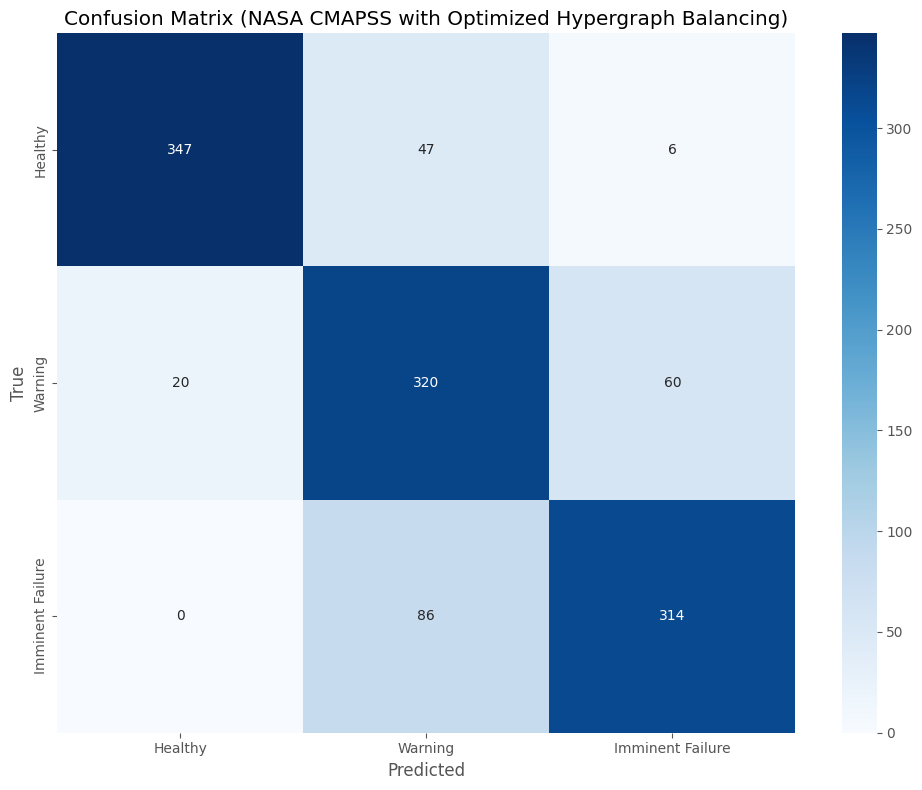


Generating SHAP explanations...
Using KernelExplainer for SHAP (model-agnostic approach)


  0%|          | 0/50 [00:00<?, ?it/s]

<Figure size 1200x800 with 0 Axes>

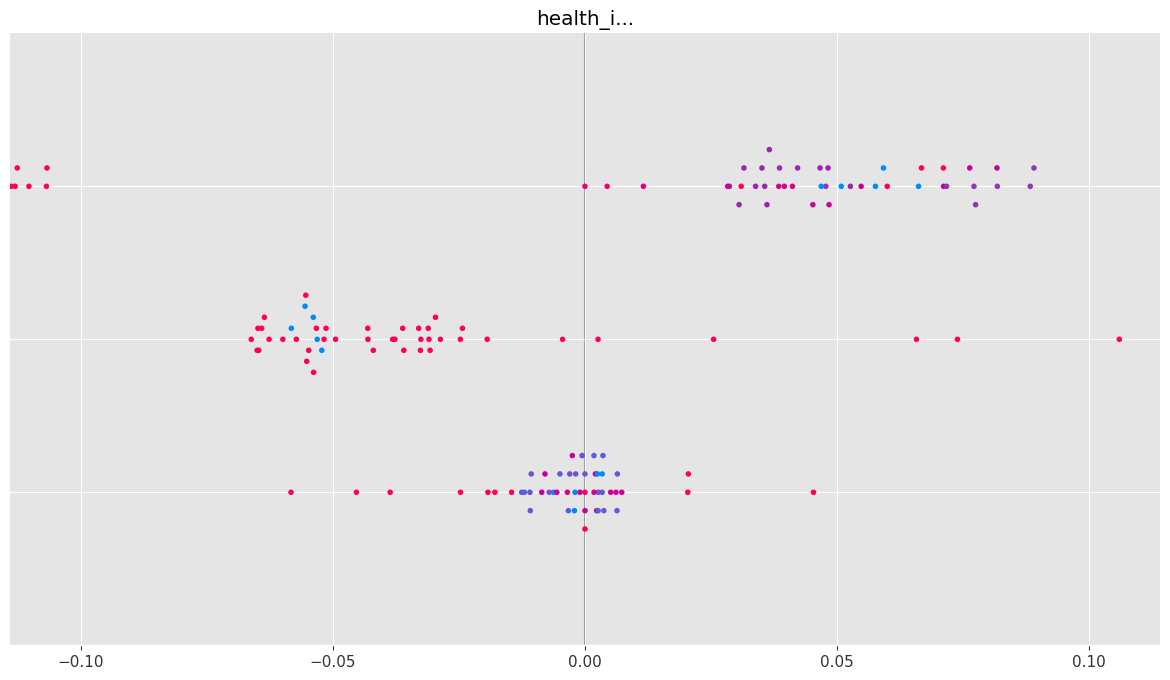

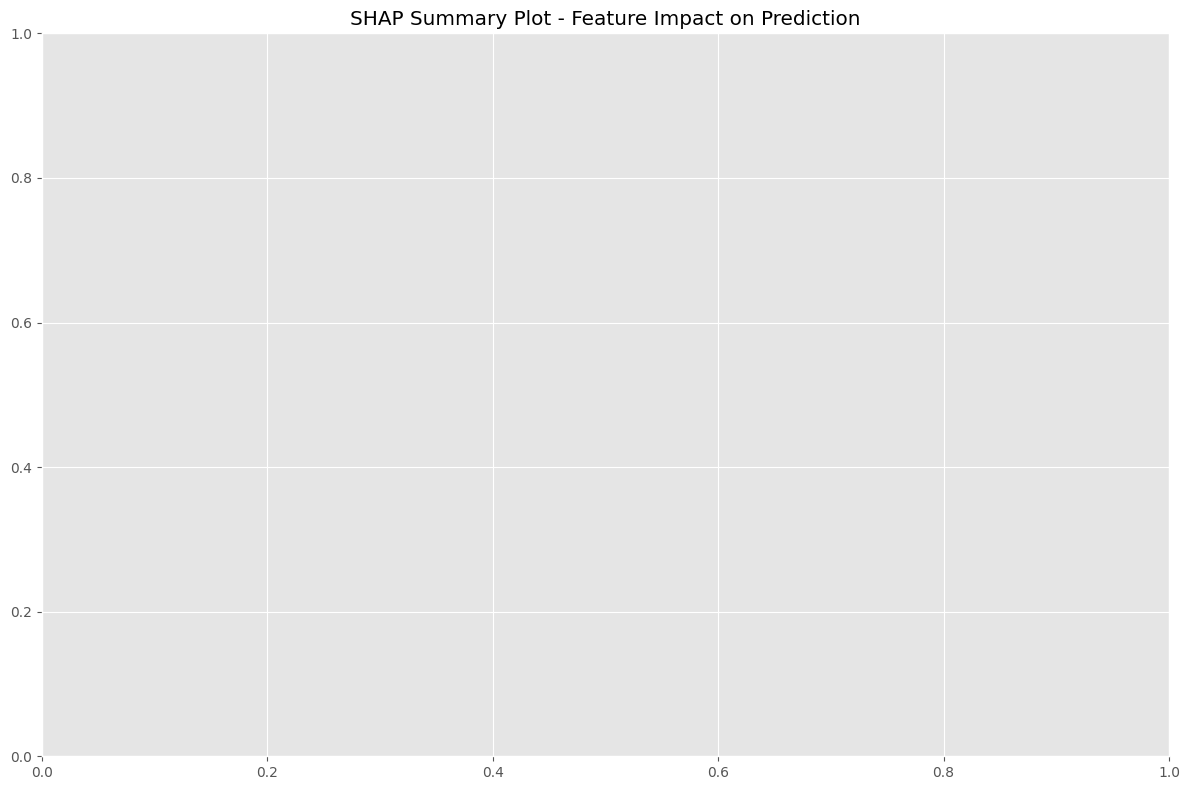

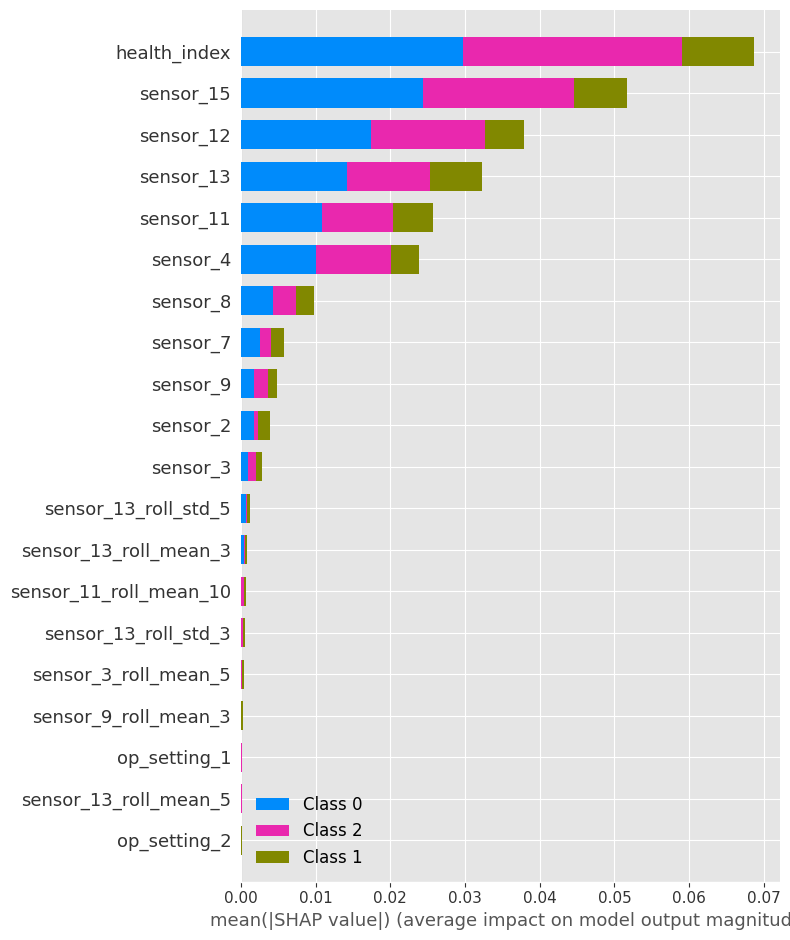

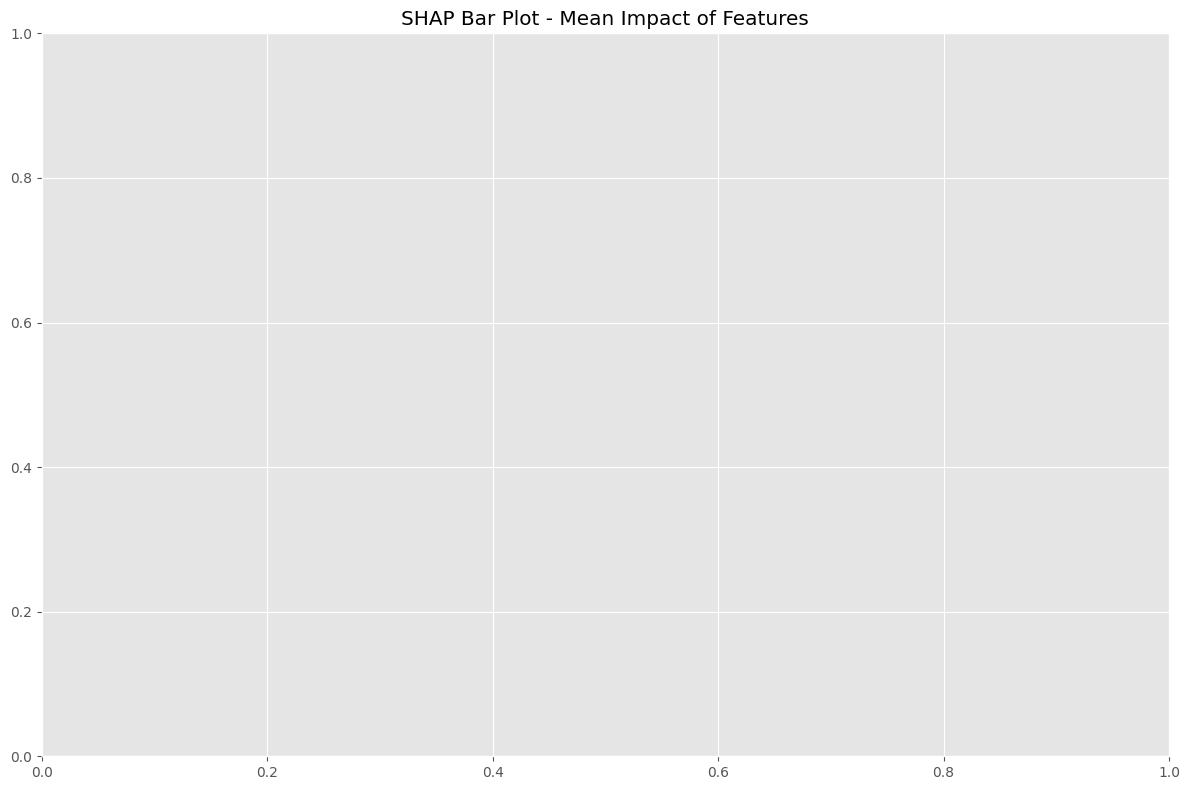

Error generating SHAP explanations: only length-1 arrays can be converted to Python scalars

Generating LIME explanations...


Traceback (most recent call last):
  File "<ipython-input-2-743351d5b17b>", line 329, in explain_model_with_shap
    feature_idx = int(top_indices[i])
                  ^^^^^^^^^^^^^^^^^^^
TypeError: only length-1 arrays can be converted to Python scalars


Intercept 0.3318936812986789
Prediction_local [0.34098239]
Right: 0.3728807372075295


<Figure size 1000x700 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

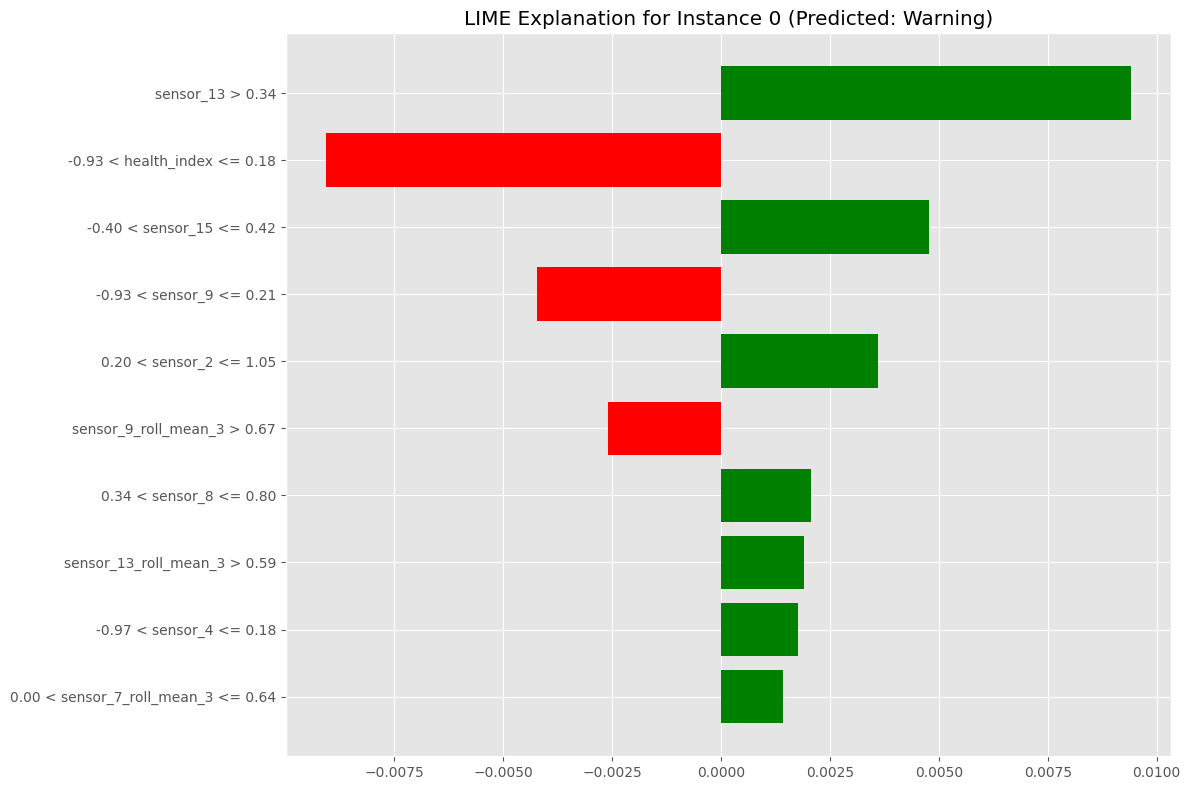


LIME Explanation for Instance 0 (Predicted: Warning):
  sensor_13 > 0.34: 0.0094
  -0.93 < health_index <= 0.18: -0.0091
  -0.40 < sensor_15 <= 0.42: 0.0048
  -0.93 < sensor_9 <= 0.21: -0.0042
  0.20 < sensor_2 <= 1.05: 0.0036
  sensor_9_roll_mean_3 > 0.67: -0.0026
  0.34 < sensor_8 <= 0.80: 0.0021
  sensor_13_roll_mean_3 > 0.59: 0.0019
  -0.97 < sensor_4 <= 0.18: 0.0018
  0.00 < sensor_7_roll_mean_3 <= 0.64: 0.0014
Intercept 0.32263910311498256
Prediction_local [0.36136516]
Right: 0.40646893695458675


<Figure size 1200x600 with 0 Axes>

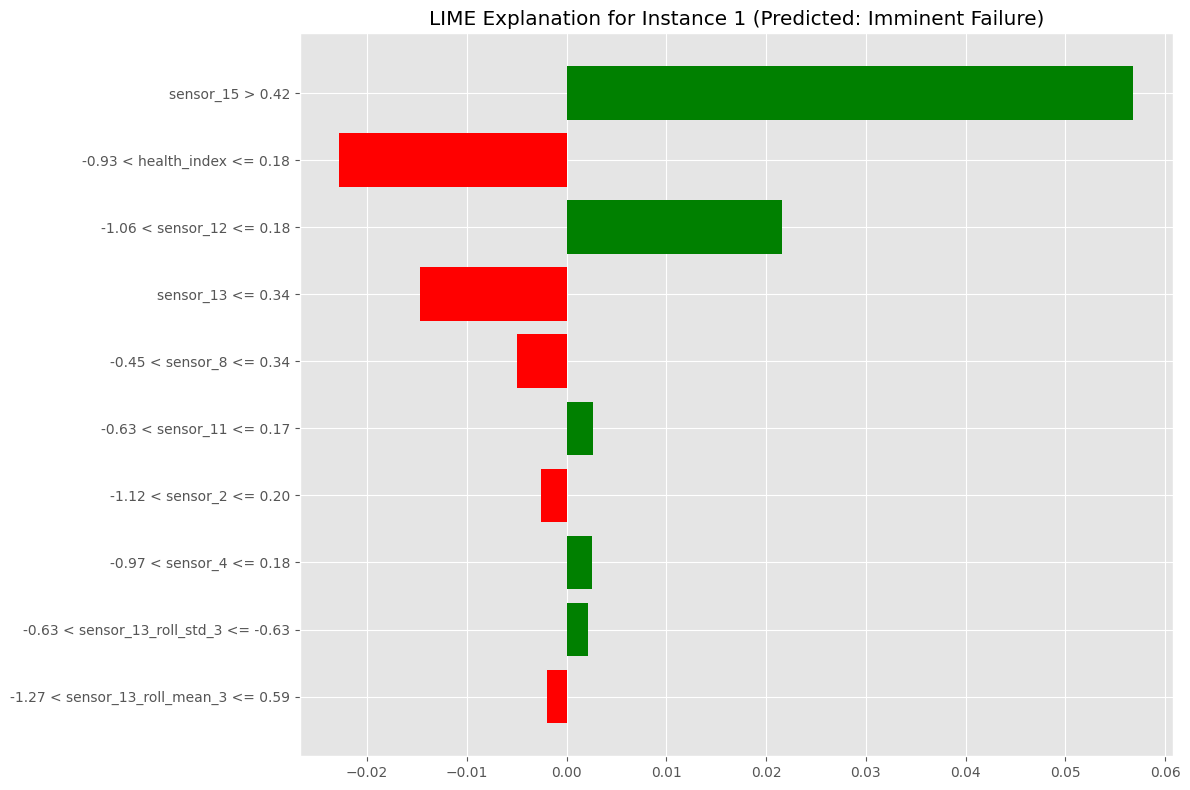

Intercept 0.3388920142795193
Prediction_local [0.32440874]
Right: 0.37368699506850284


<Figure size 1200x600 with 0 Axes>

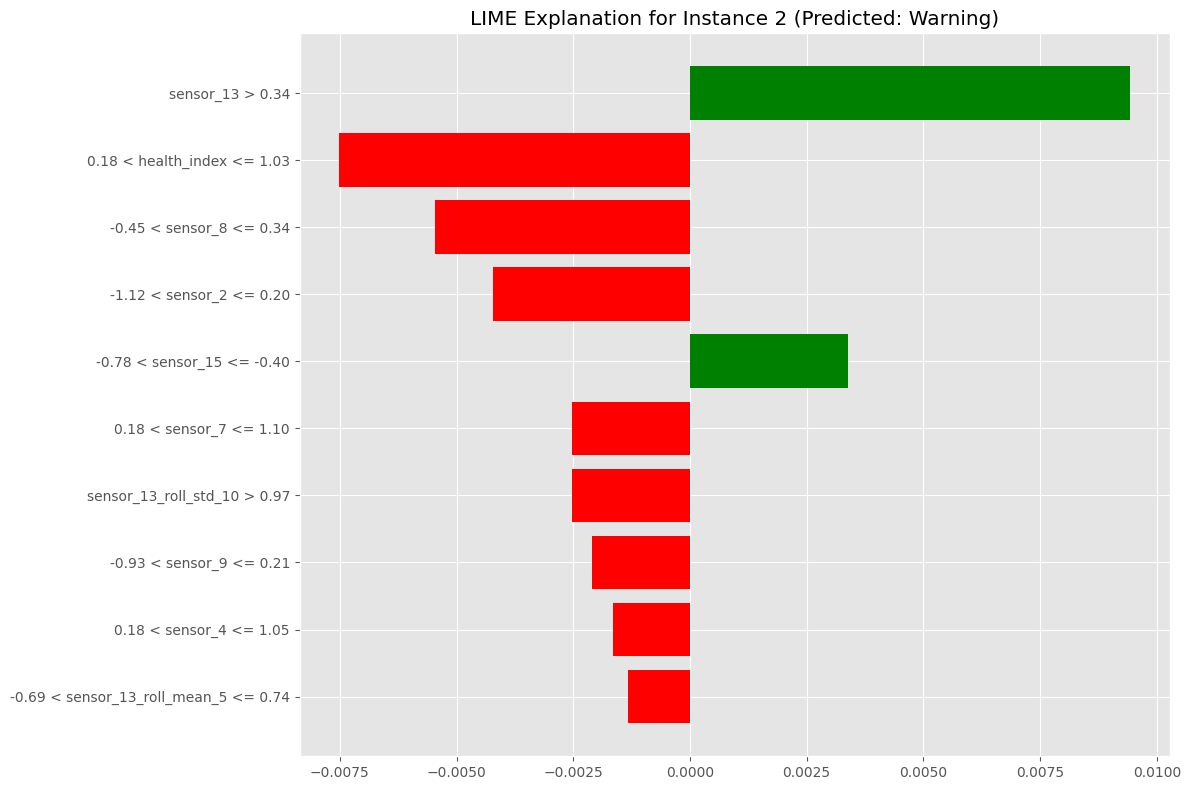

LIME explanations generated successfully.

Analyzing feature importance with permutation importance...

Top 10 features by permutation importance:
                  Feature  Importance   Std_Dev
1            health_index    0.195500  0.013251
4               sensor_15    0.150667  0.007663
2               sensor_13    0.126000  0.009150
6               sensor_12    0.077583  0.009048
0               sensor_11    0.076333  0.004732
3                sensor_4    0.033750  0.005740
9                sensor_9    0.001667  0.002297
22  sensor_13_roll_std_10    0.000917  0.000449
16   sensor_13_roll_std_5    0.000833  0.001236
10               sensor_8    0.000583  0.002740


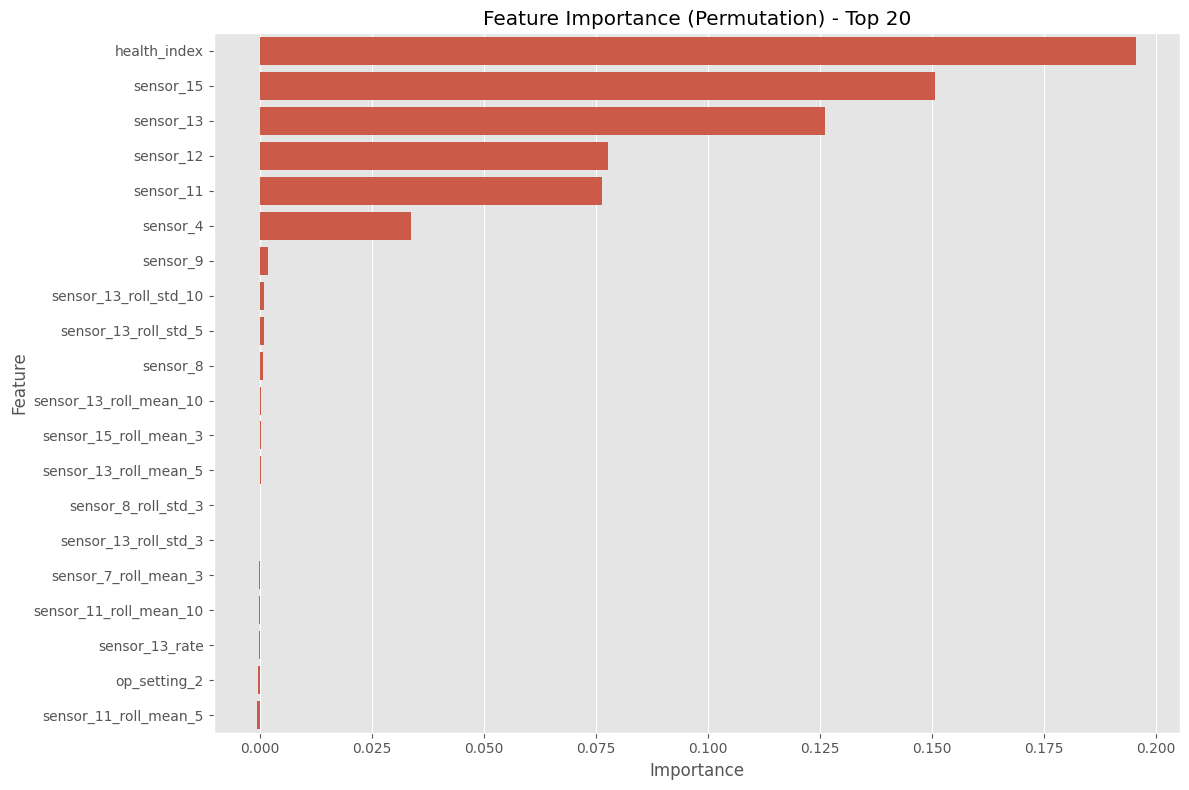


Comparing and summarizing explainable AI results...

Feature Importance Comparison:
  SHAP Top Features Permutation Top Features
0                               health_index
1                                  sensor_15
2                                  sensor_13
3                                  sensor_12
4                                  sensor_11
5                                   sensor_4
6                                   sensor_9
7                      sensor_13_roll_std_10
8                       sensor_13_roll_std_5
9                                   sensor_8


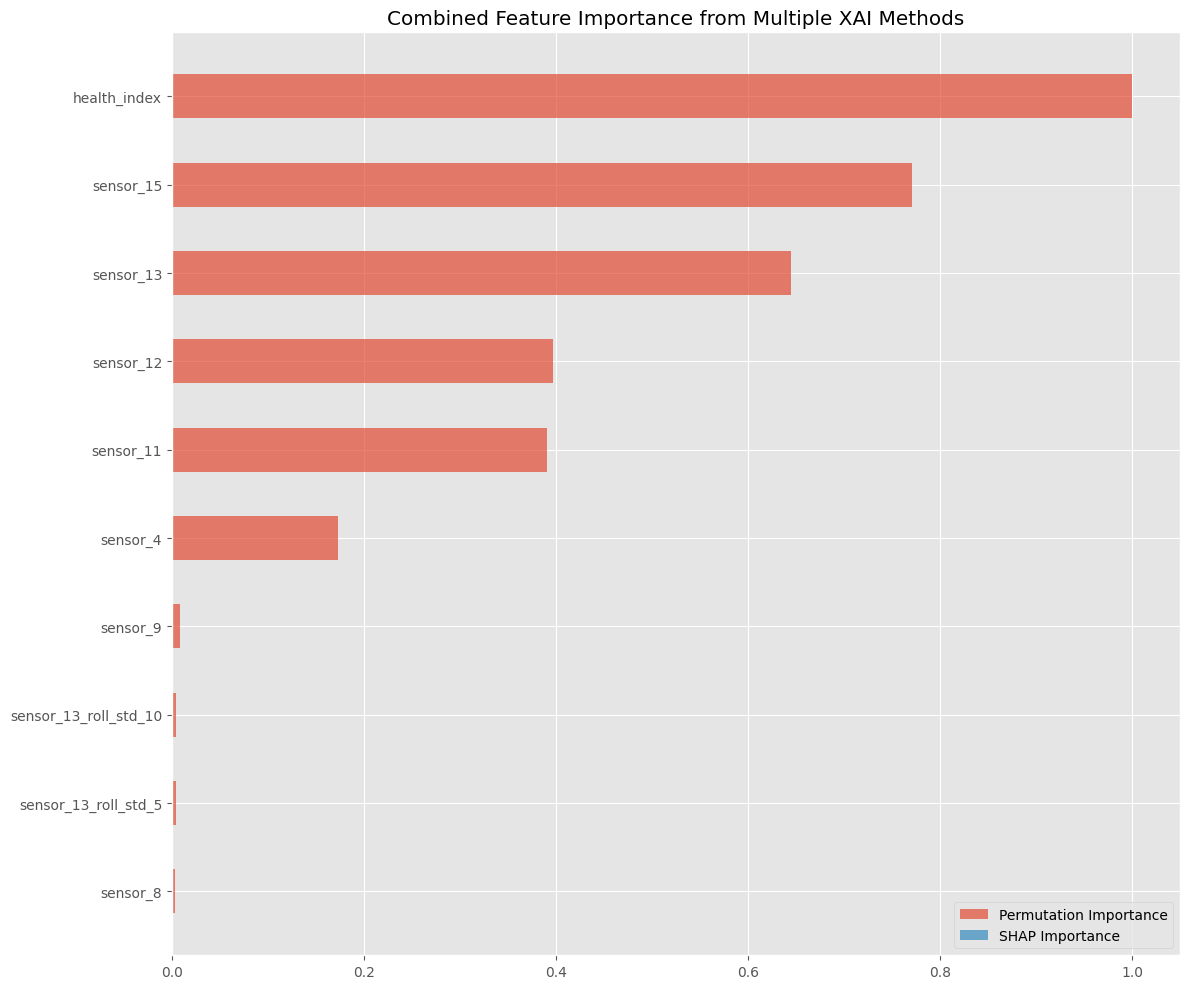


Execution time: 256.93 seconds (4.28 minutes)

Explainable AI analysis completed.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import h5py
import os
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.neighbors import NearestNeighbors
from sklearn.inspection import permutation_importance
import time
from joblib import Parallel, delayed
import warnings
warnings.filterwarnings('ignore')

# Import explainable AI libraries
import shap
from lime.lime_tabular import LimeTabularExplainer

# Configure matplotlib to display plots inline
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 8)
plt.style.use('ggplot')

# Start timing execution
start_time = time.time()

print("NASA CMAPSS Dataset - Predictive Maintenance with Explainable AI")
print("----------------------------------------------------------------")

# Data loading function for NASA CMAPSS dataset
def load_CMAPSS_data(dataset_path, fd_number):
    """Load NASA CMAPSS dataset"""
    print(f"Loading dataset FD{fd_number}...")

    # Define column names for the dataset
    col_names = ['engine_id', 'cycle', 'op_setting_1', 'op_setting_2', 'op_setting_3'] + [
        f'sensor_{i}' for i in range(1, 22)
    ]

    try:
        # Load training data
        train_file = f"{dataset_path}/train_FD{fd_number}.txt"
        train_df = pd.read_csv(train_file, sep='\s+', header=None, names=col_names)

        # Calculate RUL (Remaining Useful Life)
        grouped = train_df.groupby('engine_id')
        max_cycles = grouped['cycle'].max().reset_index()
        max_cycles.columns = ['engine_id', 'max_cycle']

        train_df = train_df.merge(max_cycles, on='engine_id')
        train_df['RUL'] = train_df['max_cycle'] - train_df['cycle']

        # Remove unnecessary columns
        train_df.drop('max_cycle', axis=1, inplace=True)

        return train_df

    except Exception as e:
        print(f"Error loading dataset FD{fd_number}: {str(e)}")
        return pd.DataFrame()

# Optimized hypergraph balancing function
def optimized_hypergraph_balancing(df, class_column, target_samples_per_class=None):
    """Efficient hypergraph-based balancing with optimized processing"""
    print("Performing optimized hypergraph-based balancing...")

    # Get class counts and determine if balancing is needed
    class_counts = df[class_column].value_counts()
    print(f"Original class distribution: {class_counts.to_dict()}")

    # Determine target samples per class
    if target_samples_per_class is None:
        target_samples_per_class = class_counts.max()
        print(f"Target samples per class set to: {target_samples_per_class}")

    # Use parallel processing for efficiency
    balanced_dfs = Parallel(n_jobs=-1)(
        delayed(balance_single_class)(
            df, class_label, class_counts[class_label], target_samples_per_class, class_column
        ) for class_label in class_counts.index
    )

    # Combine all balanced dataframes
    balanced_df = pd.concat(balanced_dfs, ignore_index=True)

    # Verify the balanced class distribution
    balanced_counts = balanced_df[class_column].value_counts()
    print(f"Balanced class distribution: {balanced_counts.to_dict()}")

    return balanced_df

# Helper function for parallelized class balancing
def balance_single_class(df, class_label, class_size, target_samples, class_column):
    """Process a single class for balancing - for parallel execution"""
    # Filter data for this class
    class_data = df[df[class_column] == class_label]

    # Fast path for classes that already have enough samples
    if class_size >= target_samples:
        return class_data.sample(target_samples)

    # For classes that need upsampling, use hypergraph-based approach
    print(f"Applying hypergraph-based selection for class {class_label}")

    # Extract features for hypergraph construction - exclude non-feature columns
    exclude_cols = ['engine_id', 'cycle', 'RUL', class_column]
    feature_cols = [col for col in class_data.columns if col not in exclude_cols]

    X = class_data[feature_cols].values

    if len(X) <= 1:
        # If only one sample in class, just duplicate it
        return pd.concat([class_data] * target_samples).head(target_samples)

    # Efficient implementation of k-nearest neighbors using Ball Tree
    k = min(15, len(X) - 1)  # Number of neighbors
    nn = NearestNeighbors(n_neighbors=k+1, algorithm='ball_tree', n_jobs=-1)
    nn.fit(X)
    distances, indices = nn.kneighbors(X)

    # Vectorized calculation of confidence scores
    confidence_scores = np.mean(distances[:, 1:], axis=1)

    # Divide samples into approximation regions
    confidence_threshold = np.percentile(confidence_scores, 70)
    lower_approx_indices = np.where(confidence_scores < confidence_threshold)[0]
    boundary_indices = np.where(confidence_scores >= confidence_threshold)[0]

    # Calculate how many more samples we need
    remaining_samples = target_samples - len(lower_approx_indices)

    if remaining_samples > 0 and len(boundary_indices) > 0:
        # Select samples from boundary region efficiently
        boundary_probs = 1.0 / (1.0 + confidence_scores[boundary_indices])
        boundary_probs = boundary_probs / boundary_probs.sum()

        # Sample with replacement if needed
        replace = remaining_samples > len(boundary_indices)

        # Use efficient numpy operations
        selected_boundary = np.random.choice(
            boundary_indices,
            size=min(remaining_samples, len(boundary_indices)),
            replace=replace,
            p=boundary_probs
        )

        # Combine regions
        selected_indices = np.concatenate([lower_approx_indices, selected_boundary])
    else:
        selected_indices = lower_approx_indices

    # Handle edge cases efficiently
    if len(selected_indices) < target_samples:
        # Need more samples - duplicate some
        remaining = target_samples - len(selected_indices)
        duplicates = np.random.choice(range(len(X)), size=remaining, replace=True)
        selected_indices = np.concatenate([selected_indices, duplicates])
    elif len(selected_indices) > target_samples:
        # Too many samples - select subset
        selected_indices = np.random.choice(selected_indices, size=target_samples, replace=False)

    # Return balanced samples for this class
    return class_data.iloc[selected_indices].reset_index(drop=True)

# Efficient time-based feature creation with parallel processing
def create_time_features(df, sensors, window_sizes=[3, 5, 10]):
    """Create time-based features efficiently using parallel processing"""
    print("Creating time-based features with parallel processing...")

    # Sort data for accurate rolling calculations
    df = df.sort_values(['engine_id', 'cycle'])

    # Define operations to run in parallel
    def process_sensor_window(sensor, window):
        # Create mean features
        mean_name = f'{sensor}_roll_mean_{window}'
        mean_series = df.groupby('engine_id')[sensor].transform(
            lambda x: x.rolling(window, min_periods=1).mean())

        # Create std features
        std_name = f'{sensor}_roll_std_{window}'
        std_series = df.groupby('engine_id')[sensor].transform(
            lambda x: x.rolling(window, min_periods=1).std().fillna(0))

        return {mean_name: mean_series, std_name: std_series}

    # Run rolling window calculations in parallel
    results = Parallel(n_jobs=-1)(
        delayed(process_sensor_window)(sensor, window)
        for sensor in sensors
        for window in window_sizes
    )

    # Add results to dataframe
    for result in results:
        for name, series in result.items():
            df[name] = series

    # Add rate features more efficiently
    for sensor in sensors:
        # Calculate difference between consecutive sensor readings
        df[f'{sensor}_rate'] = df.groupby('engine_id')[sensor].diff().fillna(0)

        # Normalize by cycle difference
        cycle_diff = df.groupby('engine_id')['cycle'].diff().fillna(1)
        df[f'{sensor}_rate'] = df[f'{sensor}_rate'] / np.where(cycle_diff == 0, 1, cycle_diff)

    return df

# Create health index feature
def create_health_index(df, sensor_columns):
    """Create a health index feature based on multiple sensor readings"""
    print("Creating health index feature...")

    # Create a copy to avoid modifying original data
    normalized_sensors = df[sensor_columns].copy()

    # Normalize all sensors at once using vectorized operations
    for col in sensor_columns:
        min_val = df[col].min()
        max_val = df[col].max()

        # Handle case where min and max are the same
        if min_val == max_val:
            normalized_sensors[col] = 0.5
        else:
            normalized_sensors[col] = (df[col] - min_val) / (max_val - min_val)

    # Calculate health index efficiently
    df['health_index'] = normalized_sensors.mean(axis=1)

    return df

# Create three-class labels
def create_multiclass_labels(df, thresholds=[15, 30, 90]):
    """Create multi-class labels based on RUL thresholds"""
    print(f"Creating multi-class labels with thresholds {thresholds}...")

    # Create labels: 0 = healthy, 1 = warning, 2 = imminent failure
    conditions = [
        (df['RUL'] <= thresholds[0]),                               # Imminent failure
        (df['RUL'] > thresholds[0]) & (df['RUL'] <= thresholds[1]), # Warning
        (df['RUL'] > thresholds[1])                                 # Healthy
    ]

    values = [2, 1, 0]  # 2 = imminent failure, 1 = warning, 0 = healthy
    df['failure_class'] = np.select(conditions, values)

    return df

# Feature selection for dimensionality reduction
def select_important_features(X_train, y_train, feature_names, n_features=None):
    """Select important features to reduce dimensionality and improve performance"""
    print("Performing feature selection...")

    # Use a fast model to identify important features
    selector = RandomForestClassifier(n_estimators=50, max_depth=5, random_state=42, n_jobs=-1)
    selector.fit(X_train, y_train)

    # Get importance scores
    importance = selector.feature_importances_
    indices = np.argsort(importance)[::-1]

    # Determine number of features to keep
    if n_features is None:
        # Use cumulative importance threshold (keep features that explain 95% of variance)
        cumulative_importance = np.cumsum(importance[indices])
        n_features = np.where(cumulative_importance >= 0.95)[0][0] + 1

    # Select top features
    selected_indices = indices[:n_features]
    selected_features = [feature_names[i] for i in selected_indices]

    print(f"Selected {len(selected_features)} features out of {len(feature_names)}")

    return selected_indices, selected_features

# SHAP explainer function for global feature importance using KernelExplainer
def explain_model_with_shap(model, X_train, X_test, selected_features):
    """Explain model predictions using SHAP values with KernelExplainer"""
    print("\nGenerating SHAP explanations...")

    try:
        # Create a sample of background data for SHAP (use smaller sample for efficiency)
        background_data = X_train[np.random.choice(X_train.shape[0], min(100, X_train.shape[0]), replace=False)]

        # Create explainer using KernelExplainer which works with any model type
        explainer = shap.KernelExplainer(model.predict_proba, background_data)
        print("Using KernelExplainer for SHAP (model-agnostic approach)")

        # Calculate SHAP values for a subset of test data
        test_sample = X_test[:50]  # Use fewer samples for faster computation
        shap_values = explainer.shap_values(test_sample)

        # For multiclass, use the class 2 (imminent failure) SHAP values for visualization
        if isinstance(shap_values, list):
            # For multiclass, use the last class (imminent failure) SHAP values
            shap_values_viz = shap_values[2]  # Class index for 'Imminent Failure'
            print("Using SHAP values for the 'Imminent Failure' class")
        else:
            shap_values_viz = shap_values

        # Create SHAP summary plot
        plt.figure(figsize=(12, 8))
        shap.summary_plot(shap_values_viz, test_sample, feature_names=np.array(selected_features))
        plt.title('SHAP Summary Plot - Feature Impact on Prediction')
        plt.tight_layout()
        plt.show()

        # Create SHAP bar plot
        plt.figure(figsize=(12, 8))
        shap.summary_plot(shap_values_viz, test_sample, feature_names=np.array(selected_features),
                        plot_type='bar')
        plt.title('SHAP Bar Plot - Mean Impact of Features')
        plt.tight_layout()
        plt.show()

        # Create SHAP dependence plots for top 3 features
        feature_importance = np.abs(shap_values_viz).mean(0)
        top_indices = np.argsort(-feature_importance)[:3]

        for i in range(min(3, len(selected_features))):
            plt.figure(figsize=(10, 7))
            feature_idx = int(top_indices[i])
            feature_name = selected_features[feature_idx]
            shap.dependence_plot(
                feature_idx,
                shap_values_viz,
                test_sample,
                feature_names=np.array(selected_features)
            )
            plt.title(f'SHAP Dependence Plot for {feature_name}')
            plt.tight_layout()
            plt.show()

        print("SHAP explanations generated successfully.")
        return shap_values, explainer

    except Exception as e:
        print(f"Error generating SHAP explanations: {str(e)}")
        import traceback
        traceback.print_exc()
        return None, None

# LIME explainer function for local feature importance
def explain_with_lime(model, X_train, X_test, y_train, selected_features, num_samples=3):
    """Explain individual predictions using LIME"""
    print("\nGenerating LIME explanations...")

    try:
        # Define class names for better visualization
        class_names = ['Healthy', 'Warning', 'Imminent Failure']

        # Create and fit LIME explainer
        lime_explainer = LimeTabularExplainer(
            X_train,
            feature_names=selected_features,
            class_names=class_names,
            mode='classification',
            verbose=True
        )

        # Generate explanations for a few test instances
        for i in range(min(num_samples, X_test.shape[0])):
            # Generate explanation
            exp = lime_explainer.explain_instance(
                X_test[i],
                model.predict_proba,
                num_features=10,  # Show top 10 features
                top_labels=1      # Explain the top predicted class
            )

            # Get predicted class
            pred_class = int(model.predict([X_test[i]])[0])

            # Display explanation figure
            plt.figure(figsize=(12, 6))
            exp.as_pyplot_figure(label=pred_class)
            plt.title(f'LIME Explanation for Instance {i} (Predicted: {class_names[pred_class]})')
            plt.tight_layout()
            plt.show()

            # Print textual explanation for the first example
            if i == 0:
                print(f"\nLIME Explanation for Instance 0 (Predicted: {class_names[pred_class]}):")
                for feat, weight in exp.as_list(label=pred_class):
                    print(f"  {feat}: {weight:.4f}")

        print("LIME explanations generated successfully.")
        return lime_explainer

    except Exception as e:
        print(f"Error generating LIME explanations: {str(e)}")
        import traceback
        traceback.print_exc()
        return None

# Main execution with efficient processing
def main():
    try:
        # Set random seed for reproducibility
        np.random.seed(42)

        # Define path to dataset
        dataset_path = './'  # Adjust as needed

        # ----------------------
        # DATA LOADING - OPTIMIZED
        # ----------------------
        print("Loading NASA CMAPSS datasets with parallel processing...")

        # Option 1: Load traditional CMAPSS dataset (FD001-004)
        subsets = ['001', '002', '003', '004']
        all_data = []

        # Load each subset in parallel
        all_data = Parallel(n_jobs=-1)(
            delayed(load_CMAPSS_data)(dataset_path, fd) for fd in subsets
        )

        # Combine all loaded datasets
        full_data = pd.concat([df for df in all_data if not df.empty], ignore_index=True)

        # Check if data was loaded successfully
        if full_data.empty:
            raise ValueError("Failed to load datasets. Please check file paths and formats.")

        print(f"Dataset loaded successfully. Shape: {full_data.shape}")

        # ----------------------
        # FEATURE ENGINEERING - OPTIMIZED
        # ----------------------

        # Identify critical sensors based on literature
        critical_sensors = [
            'sensor_2', 'sensor_3', 'sensor_4', 'sensor_7', 'sensor_8',
            'sensor_9', 'sensor_11', 'sensor_12', 'sensor_13', 'sensor_15'
        ]

        # Create time-based features efficiently
        full_data = create_time_features(full_data, critical_sensors, window_sizes=[3, 5, 10])

        # Create health index
        full_data = create_health_index(full_data, critical_sensors)

        # Create class labels
        full_data = create_multiclass_labels(full_data, thresholds=[15, 30, 90])

        # Check class distribution before balancing
        class_distribution = full_data['failure_class'].value_counts()
        print("\nClass distribution before balancing:")
        print(class_distribution)

        # ----------------------
        # OPTIMIZED HYPERGRAPH BALANCING
        # ----------------------

        # Apply optimized hypergraph-based balancing
        balanced_data = optimized_hypergraph_balancing(full_data, 'failure_class', target_samples_per_class=2000)

        # Create feature set
        features = critical_sensors + \
                  [f'{sensor}_roll_mean_{w}' for sensor in critical_sensors for w in [3, 5, 10]] + \
                  [f'{sensor}_roll_std_{w}' for sensor in critical_sensors for w in [3, 5, 10]] + \
                  [f'{sensor}_rate' for sensor in critical_sensors] + \
                  ['op_setting_1', 'op_setting_2', 'op_setting_3', 'health_index']

        # Drop rows with NaN values
        print(f"Shape before dropping NaN values: {balanced_data.shape}")
        balanced_data = balanced_data.dropna()
        print(f"Shape after dropping NaN values: {balanced_data.shape}")

        # ----------------------
        # MODEL TRAINING - OPTIMIZED
        # ----------------------

        # Prepare features and target
        X = balanced_data[features].values
        y = balanced_data['failure_class'].values

        # Check for and handle problematic values
        mask = np.isfinite(X).all(axis=1)
        if not all(mask):
            print(f"Found {(~mask).sum()} rows with non-finite values. Removing them.")
            X = X[mask]
            y = y[mask]

        # Split data into train and test sets
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42, stratify=y
        )

        # Normalize features
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        # Perform feature selection to reduce dimensionality
        selected_indices, selected_features = select_important_features(
            X_train_scaled, y_train, features, n_features=30
        )

        # Use selected features only
        X_train_reduced = X_train_scaled[:, selected_indices]
        X_test_reduced = X_test_scaled[:, selected_indices]

        # Set up parameter grid for faster hyperparameter tuning
        param_grid = {
            'estimator': [DecisionTreeClassifier(max_depth=d) for d in [3, 5]],
            'n_estimators': [50, 100],
            'learning_rate': [0.1, 0.5]
        }

        # Create and train AdaBoost classifier with efficient hyperparameter tuning
        print("\nTraining AdaBoost classifier with optimized hyperparameter tuning...")

        # Use reduced CV for faster execution
        ada_base = AdaBoostClassifier(random_state=42)
        grid_search = GridSearchCV(
            ada_base,
            param_grid,
            cv=3,  # Reduced from 5 for faster execution
            scoring='accuracy',
            n_jobs=-1,
            verbose=1
        )

        # Train on reduced feature set
        grid_search.fit(X_train_reduced, y_train)

        print(f"Best parameters: {grid_search.best_params_}")

        # Get the best model
        best_model = grid_search.best_estimator_

        # Predict on test set
        y_pred = best_model.predict(X_test_reduced)

        # Calculate metrics
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='weighted')
        recall = recall_score(y_test, y_pred, average='weighted')
        f1 = f1_score(y_test, y_pred, average='weighted')

        print("\nModel Performance Metrics:")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1 Score: {f1:.4f}")

        # Define class names
        class_names = ['Healthy', 'Warning', 'Imminent Failure']

        # Classification report
        print("\nClassification Report:")
        print(classification_report(y_test, y_pred, target_names=class_names))

        # Confusion Matrix
        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=class_names,
                    yticklabels=class_names)
        plt.title('Confusion Matrix (NASA CMAPSS with Optimized Hypergraph Balancing)')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.tight_layout()
        plt.show()

        # ----------------------
        # EXPLAINABLE AI SECTION
        # ----------------------

        # 1. SHAP Explanations with model-agnostic KernelExplainer
        shap_values, shap_explainer = explain_model_with_shap(
            best_model, X_train_reduced, X_test_reduced, selected_features
        )

        # 2. LIME Explanations
        lime_explainer = explain_with_lime(
            best_model, X_train_reduced, X_test_reduced, y_train, selected_features, num_samples=3
        )

        # 3. Analyze feature importance with permutation importance
        print("\nAnalyzing feature importance with permutation importance...")
        perm_importance = permutation_importance(
            best_model, X_test_reduced, y_test, n_repeats=10, random_state=42, n_jobs=-1
        )

        # Create Permutation Importance DataFrame
        perm_importance_df = pd.DataFrame({
            'Feature': selected_features,
            'Importance': perm_importance.importances_mean,
            'Std_Dev': perm_importance.importances_std
        }).sort_values('Importance', ascending=False)

        print("\nTop 10 features by permutation importance:")
        print(perm_importance_df.head(10))

        # Plot permutation importance
        plt.figure(figsize=(12, 8))
        top_features = perm_importance_df.head(20)
        sns.barplot(x='Importance', y='Feature', data=top_features)
        plt.title('Feature Importance (Permutation) - Top 20')
        plt.tight_layout()
        plt.show()

        # 4. Compare and summarize all explainable AI results
        print("\nComparing and summarizing explainable AI results...")

        # Get top 10 features from each method
        try:
            # If SHAP values is a list (multi-class), use the last class (imminent failure)
            if isinstance(shap_values, list):
                shap_importance = np.abs(shap_values[2]).mean(0)
            else:
                shap_importance = np.abs(shap_values).mean(0)

            shap_top_indices = np.argsort(-shap_importance)[:10]
            shap_top_features = [selected_features[i] for i in shap_top_indices]
        except:
            shap_top_features = []

        perm_top_features = perm_importance_df['Feature'].head(10).tolist()

        # Create comparison DataFrame
        comparison_df = pd.DataFrame({
            'SHAP Top Features': shap_top_features[:10] + [''] * (10 - len(shap_top_features[:10])),
            'Permutation Top Features': perm_top_features + [''] * (10 - len(perm_top_features))
        })

        print("\nFeature Importance Comparison:")
        print(comparison_df)

        # Generate feature importance summary plot combining methods
        combined_features = list(set(shap_top_features[:10] + perm_top_features[:10]))[:15]
        combined_df = pd.DataFrame({'Feature': combined_features})

        # Add importance from each method
        for feature in combined_features:
            # Permutation importance
            if feature in perm_importance_df['Feature'].values:
                idx = perm_importance_df[perm_importance_df['Feature'] == feature].index[0]
                combined_df.loc[combined_df['Feature'] == feature, 'Permutation Importance'] = perm_importance_df.loc[idx, 'Importance']
            else:
                combined_df.loc[combined_df['Feature'] == feature, 'Permutation Importance'] = 0

            # SHAP importance
            try:
                if feature in selected_features:
                    feature_idx = selected_features.index(feature)
                    if isinstance(shap_values, list):
                        # For multi-class, use the values for imminent failure (class 2)
                        combined_df.loc[combined_df['Feature'] == feature, 'SHAP Importance'] = np.abs(shap_values[2][:, feature_idx]).mean()
                    else:
                        combined_df.loc[combined_df['Feature'] == feature, 'SHAP Importance'] = np.abs(shap_values[:, feature_idx]).mean()
                else:
                    combined_df.loc[combined_df['Feature'] == feature, 'SHAP Importance'] = 0
            except:
                combined_df.loc[combined_df['Feature'] == feature, 'SHAP Importance'] = 0

        # Normalize importance values for better comparison
        for col in ['Permutation Importance', 'SHAP Importance']:
            if col in combined_df.columns:
                max_val = combined_df[col].max()
                if max_val > 0:
                    combined_df[col] = combined_df[col] / max_val

        # Sort by average importance
        importance_cols = [col for col in combined_df.columns if 'Importance' in col]
        if importance_cols:
            combined_df['Average Importance'] = combined_df[importance_cols].mean(axis=1)
            combined_df = combined_df.sort_values('Average Importance', ascending=False)

        # Plot combined importance
        if 'Average Importance' in combined_df.columns:
            plt.figure(figsize=(12, 10))
            combined_df = combined_df.sort_values('Average Importance', ascending=True)

            # Create a colorful bar plot
            ax = plt.subplot(111)
            for i, col in enumerate(importance_cols):
                ax.barh(combined_df['Feature'], combined_df[col], left=i*0.1, height=0.5,
                        alpha=0.7, label=col)

            plt.legend()
            plt.title('Combined Feature Importance from Multiple XAI Methods')
            plt.tight_layout()
            plt.show()

        # Calculate execution time
        execution_time = time.time() - start_time
        print(f"\nExecution time: {execution_time:.2f} seconds ({execution_time/60:.2f} minutes)")

        print("\nExplainable AI analysis completed.")

    except Exception as e:
        print(f"An error occurred: {str(e)}")
        import traceback
        traceback.print_exc()

if __name__ == "__main__":
    main()


Random Forest

NASA CMAPSS Dataset - Predictive Maintenance with Explainable AI using Random Forest
--------------------------------------------------------------------------
Loading NASA CMAPSS datasets with parallel processing...
Dataset loaded successfully. Shape: (160359, 27)
Creating time-based features with parallel processing...
Creating health index feature...
Creating multi-class labels with thresholds [15, 30, 90]...

Class distribution before balancing:
failure_class
0    138380
2     11344
1     10635
Name: count, dtype: int64
Performing optimized hypergraph-based balancing...
Original class distribution: {0: 138380, 2: 11344, 1: 10635}
Balanced class distribution: {0: 2000, 2: 2000, 1: 2000}
Shape before dropping NaN values: (6000, 99)
Shape after dropping NaN values: (6000, 99)
Performing feature selection...
Selected 30 features out of 84

Training Random Forest classifier with optimized hyperparameter tuning...
Fitting 3 folds for each of 108 candidates, totalling 324 fits
Best parame

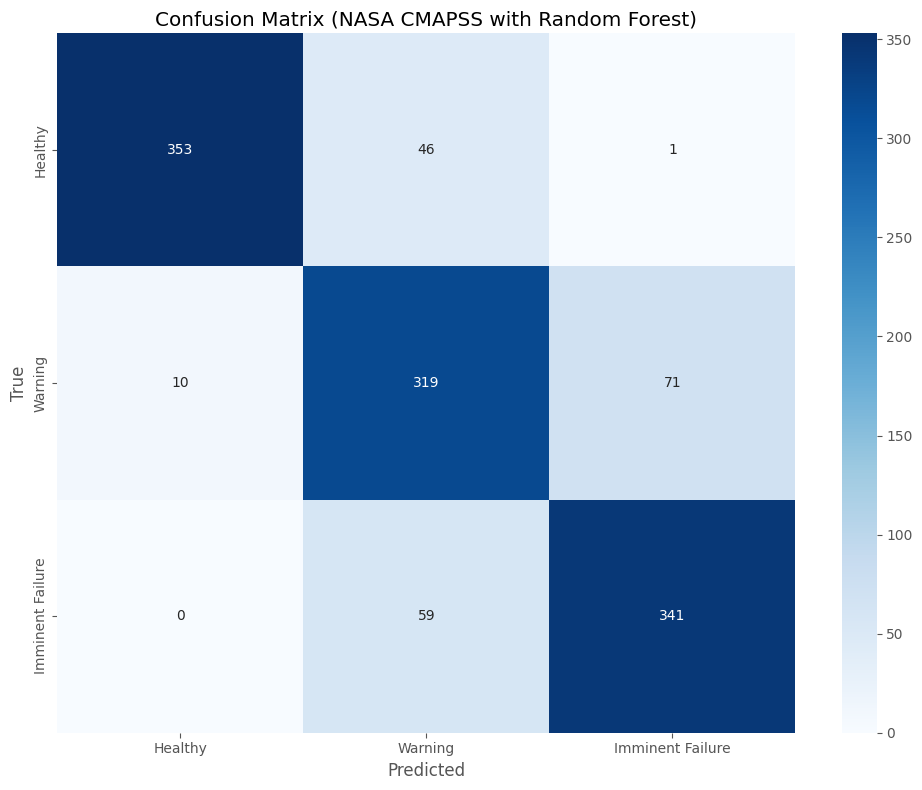


Generating SHAP explanations...
Using KernelExplainer for SHAP (model-agnostic approach)


  0%|          | 0/50 [00:00<?, ?it/s]

<Figure size 1200x800 with 0 Axes>

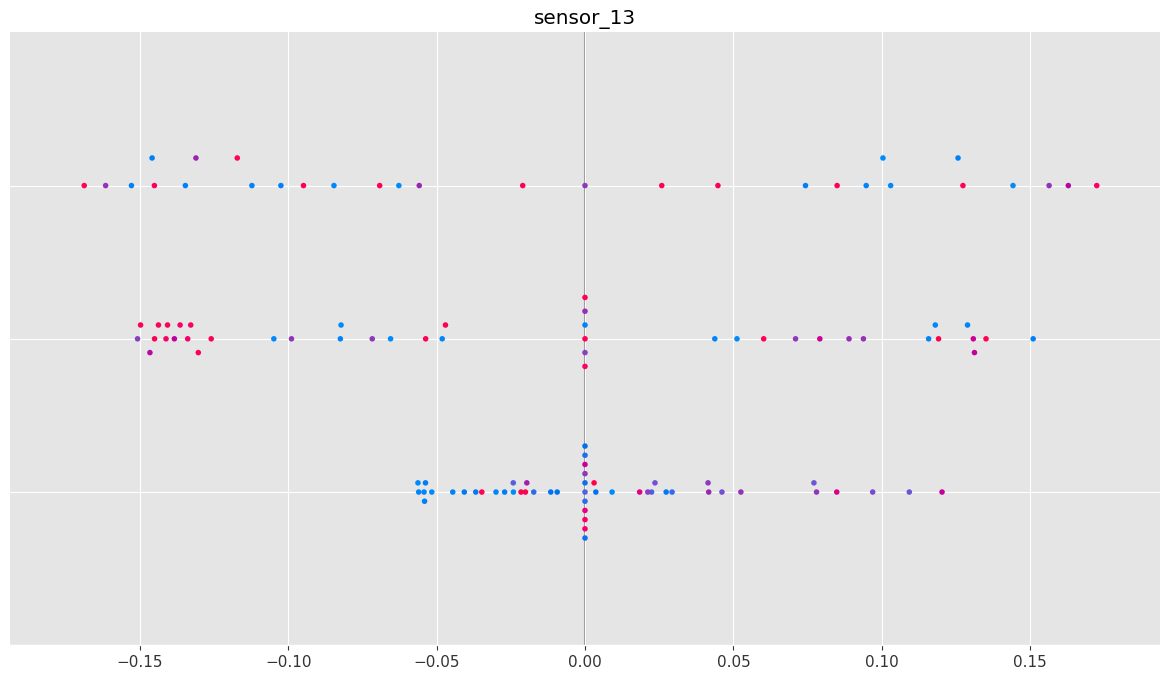

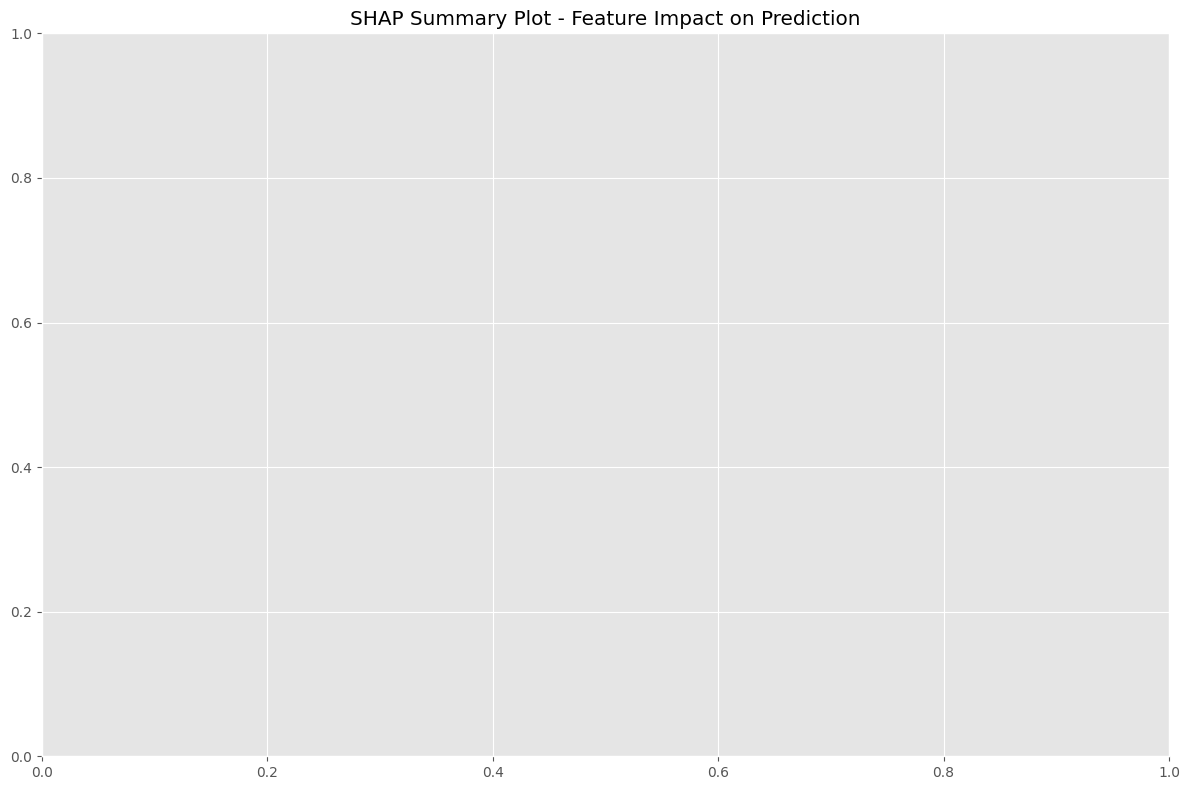

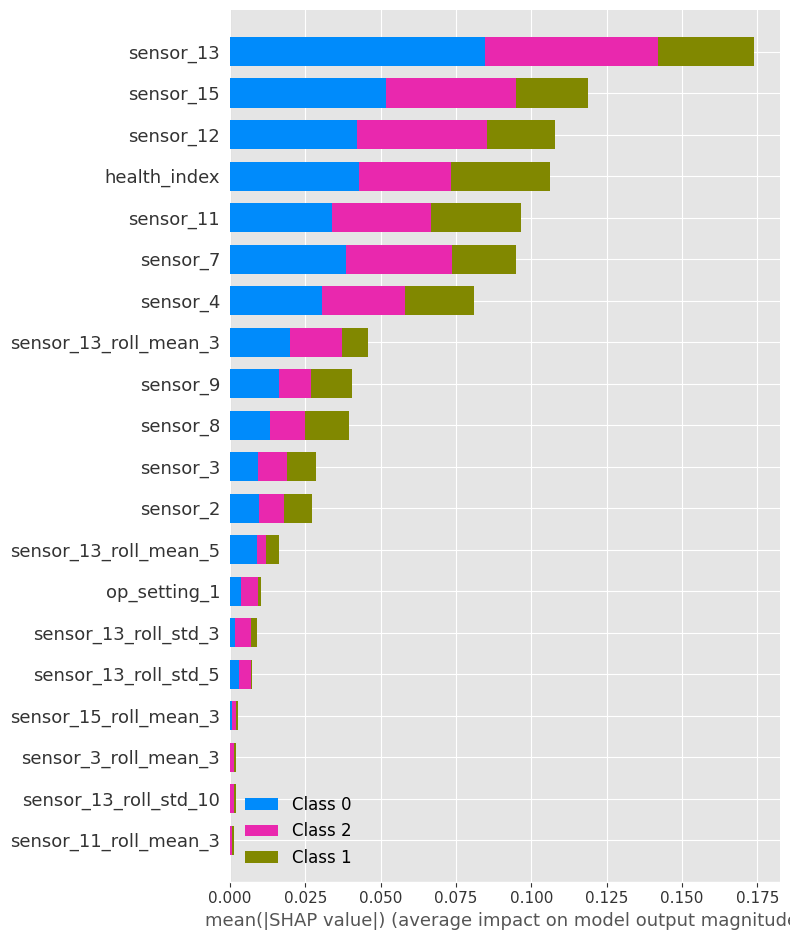

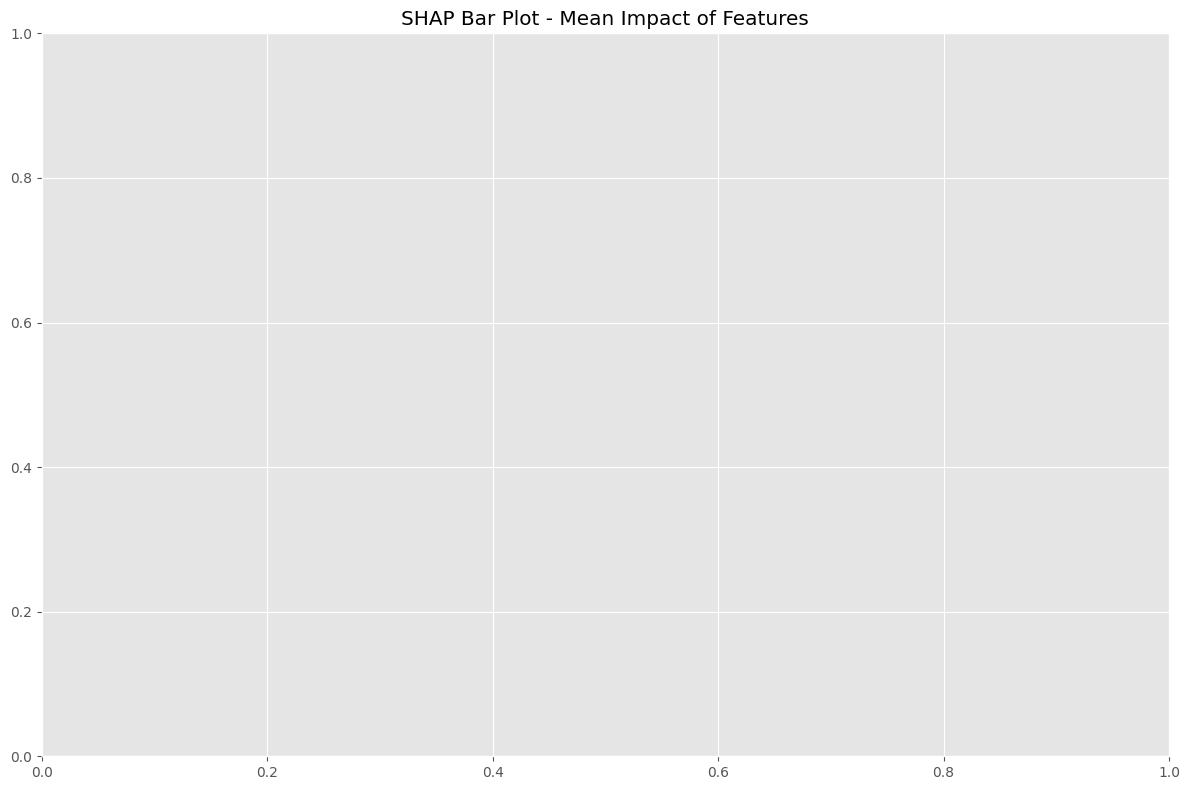

Error generating SHAP explanations: only length-1 arrays can be converted to Python scalars

Generating LIME explanations...
Intercept 0.34484953349288283
Prediction_local [0.34650456]
Right: 0.4610238095238096


Traceback (most recent call last):
  File "<ipython-input-3-081a1ea4e11e>", line 329, in explain_model_with_shap
    feature_idx = int(top_indices[i])
                  ^^^^^^^^^^^^^^^^^^^
TypeError: only length-1 arrays can be converted to Python scalars


<Figure size 1000x700 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

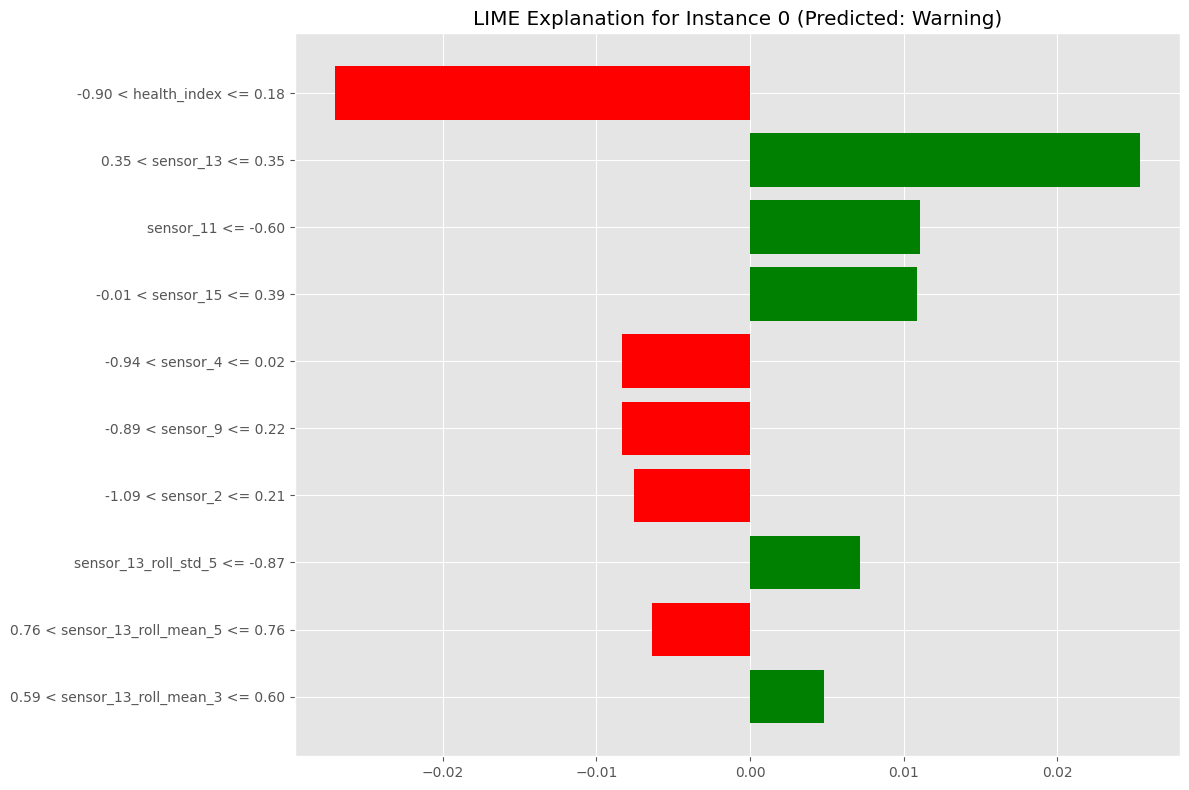


LIME Explanation for Instance 0 (Predicted: Warning):
  -0.90 < health_index <= 0.18: -0.0270
  0.35 < sensor_13 <= 0.35: 0.0254
  sensor_11 <= -0.60: 0.0111
  -0.01 < sensor_15 <= 0.39: 0.0109
  -0.94 < sensor_4 <= 0.02: -0.0084
  -0.89 < sensor_9 <= 0.22: -0.0083
  -1.09 < sensor_2 <= 0.21: -0.0076
  sensor_13_roll_std_5 <= -0.87: 0.0071
  0.76 < sensor_13_roll_mean_5 <= 0.76: -0.0064
  0.59 < sensor_13_roll_mean_3 <= 0.60: 0.0048
Intercept 0.24446937826297294
Prediction_local [0.49794985]
Right: 0.9046666666666667


<Figure size 1200x600 with 0 Axes>

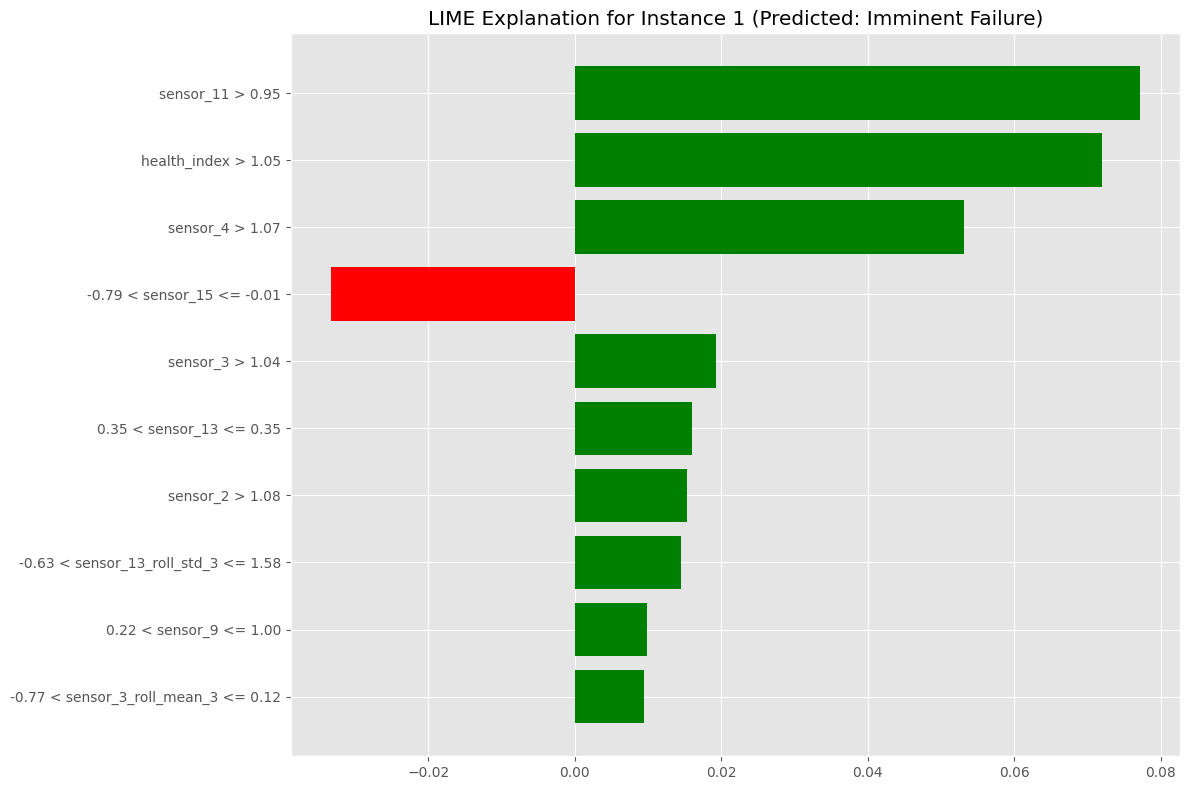

Intercept 0.3277887450160037
Prediction_local [0.40491185]
Right: 0.5503333333333333


<Figure size 1200x600 with 0 Axes>

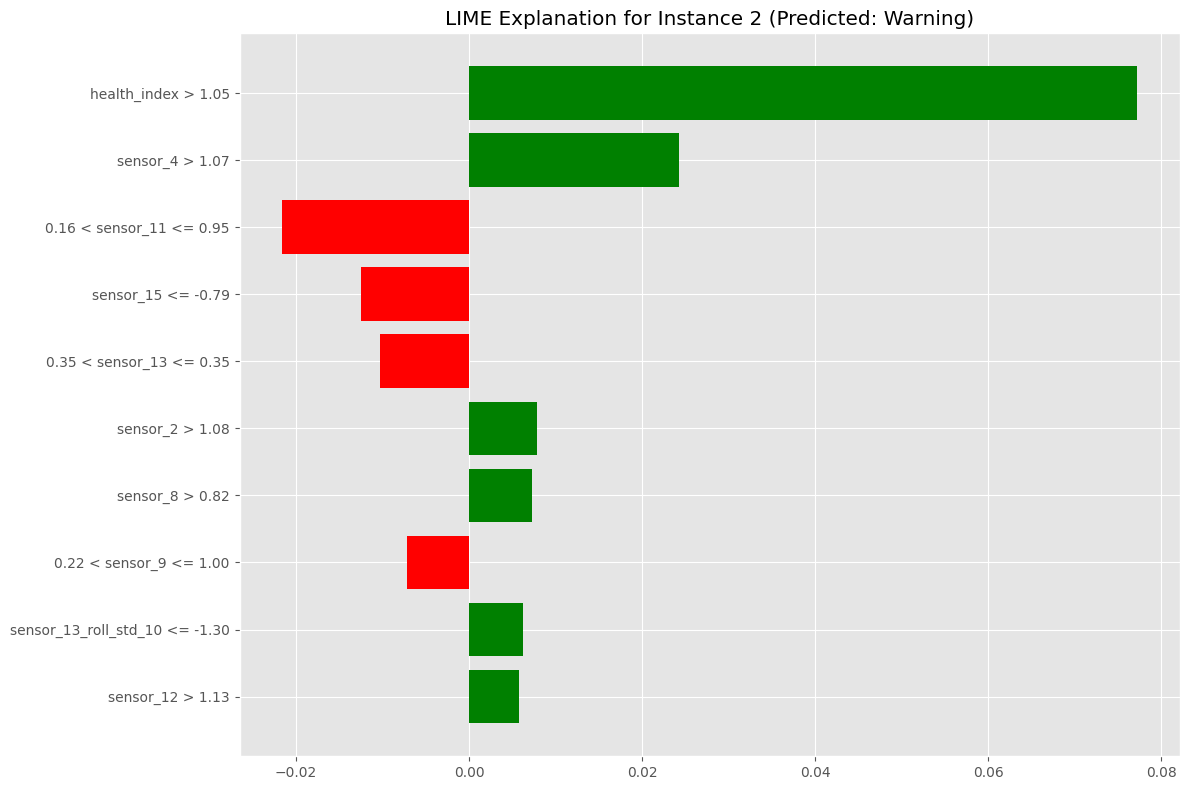

LIME explanations generated successfully.

Analyzing feature importance with permutation importance...

Top 10 features by permutation importance:
                  Feature  Importance   Std_Dev
1               sensor_13    0.079917  0.006630
5               sensor_15    0.064667  0.005299
0               sensor_11    0.049083  0.005933
3            health_index    0.040417  0.008492
2                sensor_4    0.027667  0.003551
8               sensor_12    0.024333  0.006506
11               sensor_7    0.015750  0.004022
4   sensor_13_roll_mean_3    0.007000  0.002744
9                sensor_9    0.006000  0.003158
6                sensor_2    0.005583  0.002637


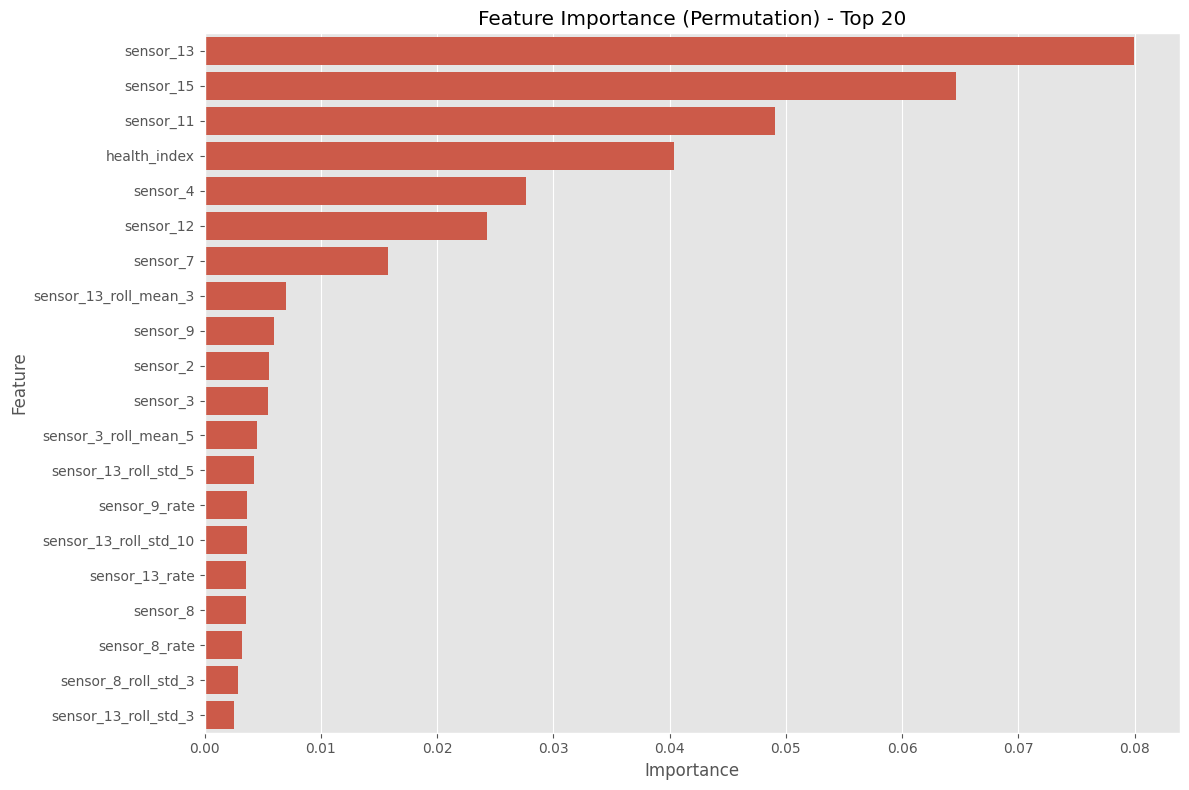


Top 10 features by Random Forest built-in importance:
         Feature  Importance
0      sensor_11    0.106712
1      sensor_13    0.098759
3   health_index    0.097979
2       sensor_4    0.079307
5      sensor_15    0.075586
8      sensor_12    0.059054
11      sensor_7    0.046231
9       sensor_9    0.041239
10      sensor_8    0.040025
6       sensor_2    0.039785


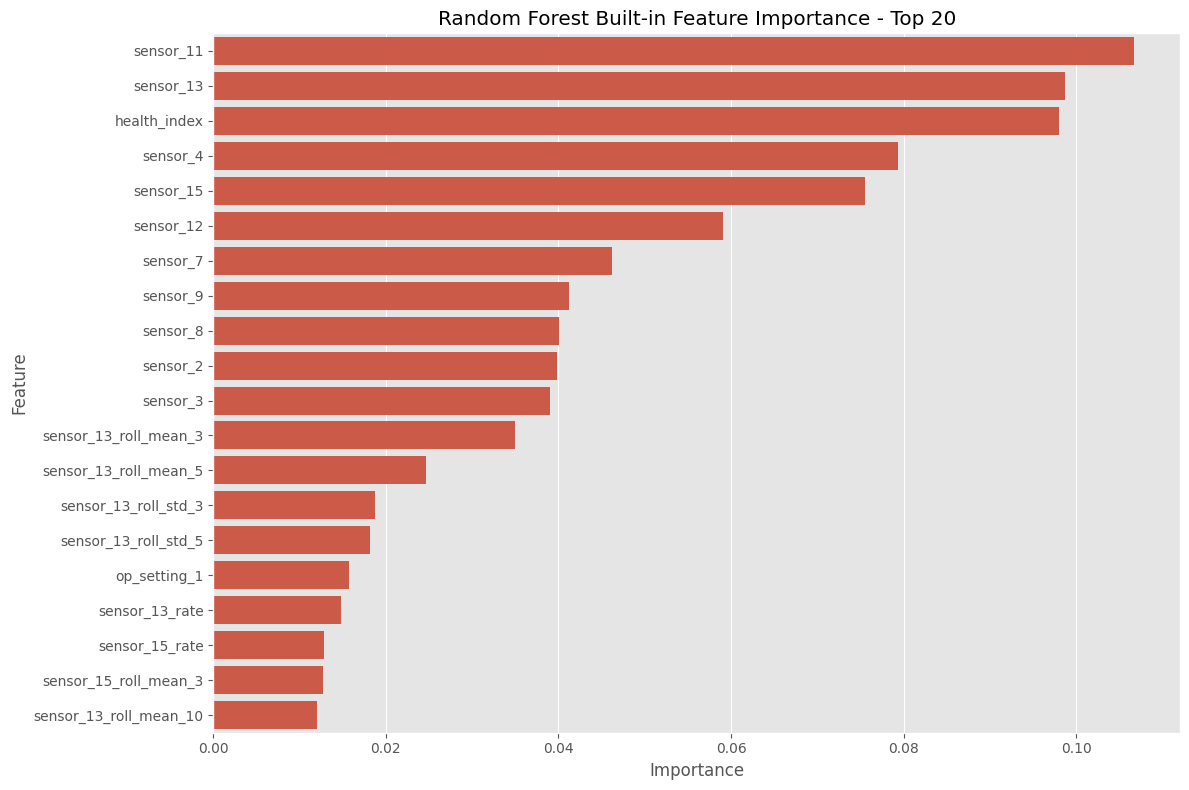


Comparing and summarizing explainable AI results...

Feature Importance Comparison:
  SHAP Top Features Permutation Top Features RF Built-in Top Features
0                                  sensor_13                sensor_11
1                                  sensor_15                sensor_13
2                                  sensor_11             health_index
3                               health_index                 sensor_4
4                                   sensor_4                sensor_15
5                                  sensor_12                sensor_12
6                                   sensor_7                 sensor_7
7                      sensor_13_roll_mean_3                 sensor_9
8                                   sensor_9                 sensor_8
9                                   sensor_2                 sensor_2


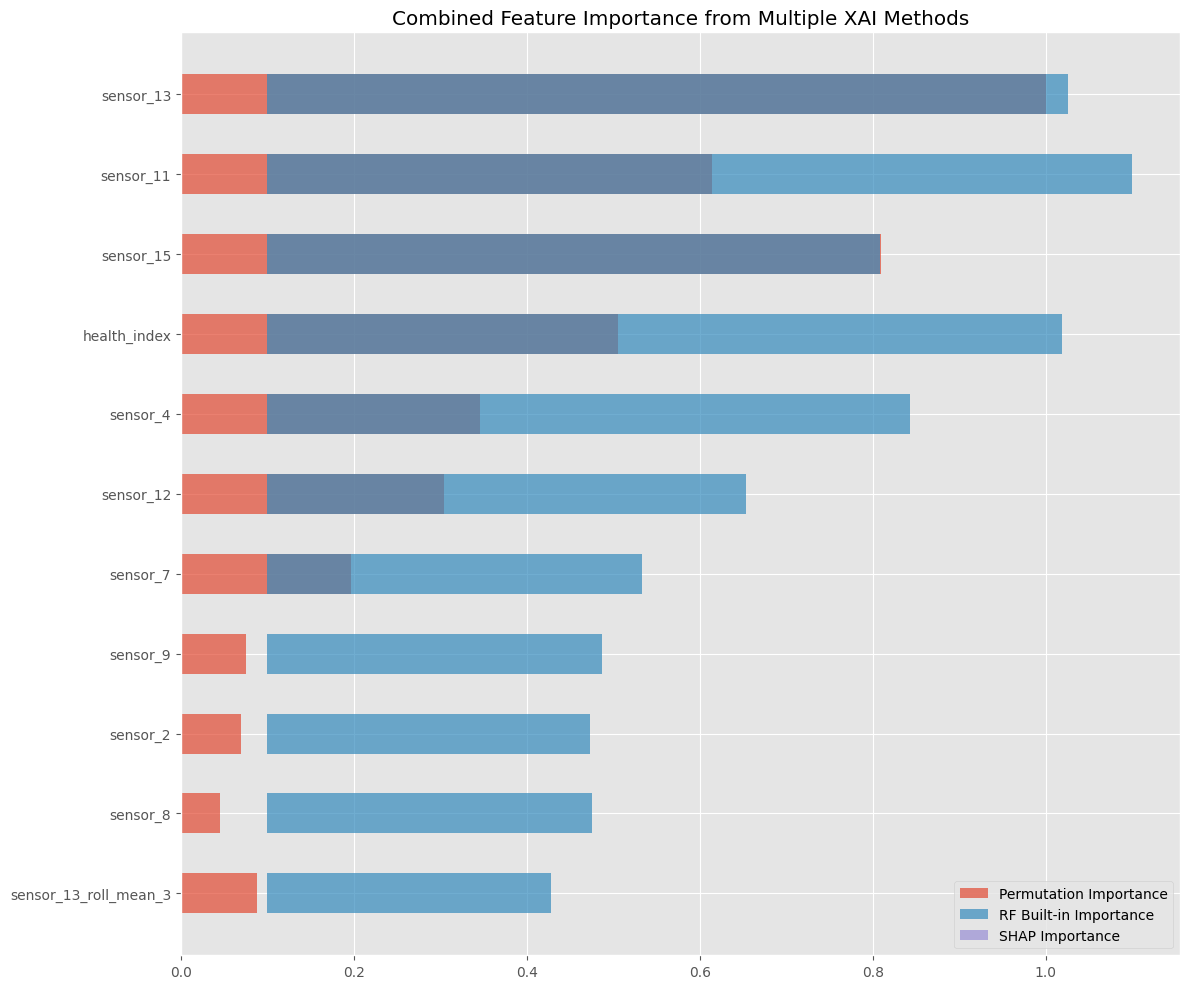


Execution time: 568.95 seconds (9.48 minutes)

Explainable AI analysis with Random Forest completed.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import h5py
import os
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.neighbors import NearestNeighbors
from sklearn.inspection import permutation_importance
import time
from joblib import Parallel, delayed
import warnings
warnings.filterwarnings('ignore')

# Import explainable AI libraries
import shap
from lime.lime_tabular import LimeTabularExplainer

# Configure matplotlib to display plots inline
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 8)
plt.style.use('ggplot')

# Start timing execution
start_time = time.time()

print("NASA CMAPSS Dataset - Predictive Maintenance with Explainable AI using Random Forest")
print("--------------------------------------------------------------------------")

# Data loading function for NASA CMAPSS dataset
def load_CMAPSS_data(dataset_path, fd_number):
    """Load NASA CMAPSS dataset"""
    print(f"Loading dataset FD{fd_number}...")

    # Define column names for the dataset
    col_names = ['engine_id', 'cycle', 'op_setting_1', 'op_setting_2', 'op_setting_3'] + [
        f'sensor_{i}' for i in range(1, 22)
    ]

    try:
        # Load training data
        train_file = f"{dataset_path}/train_FD{fd_number}.txt"
        train_df = pd.read_csv(train_file, sep='\s+', header=None, names=col_names)

        # Calculate RUL (Remaining Useful Life)
        grouped = train_df.groupby('engine_id')
        max_cycles = grouped['cycle'].max().reset_index()
        max_cycles.columns = ['engine_id', 'max_cycle']

        train_df = train_df.merge(max_cycles, on='engine_id')
        train_df['RUL'] = train_df['max_cycle'] - train_df['cycle']

        # Remove unnecessary columns
        train_df.drop('max_cycle', axis=1, inplace=True)

        return train_df

    except Exception as e:
        print(f"Error loading dataset FD{fd_number}: {str(e)}")
        return pd.DataFrame()

# Optimized hypergraph balancing function
def optimized_hypergraph_balancing(df, class_column, target_samples_per_class=None):
    """Efficient hypergraph-based balancing with optimized processing"""
    print("Performing optimized hypergraph-based balancing...")

    # Get class counts and determine if balancing is needed
    class_counts = df[class_column].value_counts()
    print(f"Original class distribution: {class_counts.to_dict()}")

    # Determine target samples per class
    if target_samples_per_class is None:
        target_samples_per_class = class_counts.max()
        print(f"Target samples per class set to: {target_samples_per_class}")

    # Use parallel processing for efficiency
    balanced_dfs = Parallel(n_jobs=-1)(
        delayed(balance_single_class)(
            df, class_label, class_counts[class_label], target_samples_per_class, class_column
        ) for class_label in class_counts.index
    )

    # Combine all balanced dataframes
    balanced_df = pd.concat(balanced_dfs, ignore_index=True)

    # Verify the balanced class distribution
    balanced_counts = balanced_df[class_column].value_counts()
    print(f"Balanced class distribution: {balanced_counts.to_dict()}")

    return balanced_df

# Helper function for parallelized class balancing
def balance_single_class(df, class_label, class_size, target_samples, class_column):
    """Process a single class for balancing - for parallel execution"""
    # Filter data for this class
    class_data = df[df[class_column] == class_label]

    # Fast path for classes that already have enough samples
    if class_size >= target_samples:
        return class_data.sample(target_samples)

    # For classes that need upsampling, use hypergraph-based approach
    print(f"Applying hypergraph-based selection for class {class_label}")

    # Extract features for hypergraph construction - exclude non-feature columns
    exclude_cols = ['engine_id', 'cycle', 'RUL', class_column]
    feature_cols = [col for col in class_data.columns if col not in exclude_cols]

    X = class_data[feature_cols].values

    if len(X) <= 1:
        # If only one sample in class, just duplicate it
        return pd.concat([class_data] * target_samples).head(target_samples)

    # Efficient implementation of k-nearest neighbors using Ball Tree
    k = min(15, len(X) - 1)  # Number of neighbors
    nn = NearestNeighbors(n_neighbors=k+1, algorithm='ball_tree', n_jobs=-1)
    nn.fit(X)
    distances, indices = nn.kneighbors(X)

    # Vectorized calculation of confidence scores
    confidence_scores = np.mean(distances[:, 1:], axis=1)

    # Divide samples into approximation regions
    confidence_threshold = np.percentile(confidence_scores, 70)
    lower_approx_indices = np.where(confidence_scores < confidence_threshold)[0]
    boundary_indices = np.where(confidence_scores >= confidence_threshold)[0]

    # Calculate how many more samples we need
    remaining_samples = target_samples - len(lower_approx_indices)

    if remaining_samples > 0 and len(boundary_indices) > 0:
        # Select samples from boundary region efficiently
        boundary_probs = 1.0 / (1.0 + confidence_scores[boundary_indices])
        boundary_probs = boundary_probs / boundary_probs.sum()

        # Sample with replacement if needed
        replace = remaining_samples > len(boundary_indices)

        # Use efficient numpy operations
        selected_boundary = np.random.choice(
            boundary_indices,
            size=min(remaining_samples, len(boundary_indices)),
            replace=replace,
            p=boundary_probs
        )

        # Combine regions
        selected_indices = np.concatenate([lower_approx_indices, selected_boundary])
    else:
        selected_indices = lower_approx_indices

    # Handle edge cases efficiently
    if len(selected_indices) < target_samples:
        # Need more samples - duplicate some
        remaining = target_samples - len(selected_indices)
        duplicates = np.random.choice(range(len(X)), size=remaining, replace=True)
        selected_indices = np.concatenate([selected_indices, duplicates])
    elif len(selected_indices) > target_samples:
        # Too many samples - select subset
        selected_indices = np.random.choice(selected_indices, size=target_samples, replace=False)

    # Return balanced samples for this class
    return class_data.iloc[selected_indices].reset_index(drop=True)

# Efficient time-based feature creation with parallel processing
def create_time_features(df, sensors, window_sizes=[3, 5, 10]):
    """Create time-based features efficiently using parallel processing"""
    print("Creating time-based features with parallel processing...")

    # Sort data for accurate rolling calculations
    df = df.sort_values(['engine_id', 'cycle'])

    # Define operations to run in parallel
    def process_sensor_window(sensor, window):
        # Create mean features
        mean_name = f'{sensor}_roll_mean_{window}'
        mean_series = df.groupby('engine_id')[sensor].transform(
            lambda x: x.rolling(window, min_periods=1).mean())

        # Create std features
        std_name = f'{sensor}_roll_std_{window}'
        std_series = df.groupby('engine_id')[sensor].transform(
            lambda x: x.rolling(window, min_periods=1).std().fillna(0))

        return {mean_name: mean_series, std_name: std_series}

    # Run rolling window calculations in parallel
    results = Parallel(n_jobs=-1)(
        delayed(process_sensor_window)(sensor, window)
        for sensor in sensors
        for window in window_sizes
    )

    # Add results to dataframe
    for result in results:
        for name, series in result.items():
            df[name] = series

    # Add rate features more efficiently
    for sensor in sensors:
        # Calculate difference between consecutive sensor readings
        df[f'{sensor}_rate'] = df.groupby('engine_id')[sensor].diff().fillna(0)

        # Normalize by cycle difference
        cycle_diff = df.groupby('engine_id')['cycle'].diff().fillna(1)
        df[f'{sensor}_rate'] = df[f'{sensor}_rate'] / np.where(cycle_diff == 0, 1, cycle_diff)

    return df

# Create health index feature
def create_health_index(df, sensor_columns):
    """Create a health index feature based on multiple sensor readings"""
    print("Creating health index feature...")

    # Create a copy to avoid modifying original data
    normalized_sensors = df[sensor_columns].copy()

    # Normalize all sensors at once using vectorized operations
    for col in sensor_columns:
        min_val = df[col].min()
        max_val = df[col].max()

        # Handle case where min and max are the same
        if min_val == max_val:
            normalized_sensors[col] = 0.5
        else:
            normalized_sensors[col] = (df[col] - min_val) / (max_val - min_val)

    # Calculate health index efficiently
    df['health_index'] = normalized_sensors.mean(axis=1)

    return df

# Create three-class labels
def create_multiclass_labels(df, thresholds=[15, 30, 90]):
    """Create multi-class labels based on RUL thresholds"""
    print(f"Creating multi-class labels with thresholds {thresholds}...")

    # Create labels: 0 = healthy, 1 = warning, 2 = imminent failure
    conditions = [
        (df['RUL'] <= thresholds[0]),                               # Imminent failure
        (df['RUL'] > thresholds[0]) & (df['RUL'] <= thresholds[1]), # Warning
        (df['RUL'] > thresholds[1])                                 # Healthy
    ]

    values = [2, 1, 0]  # 2 = imminent failure, 1 = warning, 0 = healthy
    df['failure_class'] = np.select(conditions, values)

    return df

# Feature selection for dimensionality reduction
def select_important_features(X_train, y_train, feature_names, n_features=None):
    """Select important features to reduce dimensionality and improve performance"""
    print("Performing feature selection...")

    # Use a fast model to identify important features
    selector = RandomForestClassifier(n_estimators=50, max_depth=5, random_state=42, n_jobs=-1)
    selector.fit(X_train, y_train)

    # Get importance scores
    importance = selector.feature_importances_
    indices = np.argsort(importance)[::-1]

    # Determine number of features to keep
    if n_features is None:
        # Use cumulative importance threshold (keep features that explain 95% of variance)
        cumulative_importance = np.cumsum(importance[indices])
        n_features = np.where(cumulative_importance >= 0.95)[0][0] + 1

    # Select top features
    selected_indices = indices[:n_features]
    selected_features = [feature_names[i] for i in selected_indices]

    print(f"Selected {len(selected_features)} features out of {len(feature_names)}")

    return selected_indices, selected_features

# SHAP explainer function for global feature importance using KernelExplainer
def explain_model_with_shap(model, X_train, X_test, selected_features):
    """Explain model predictions using SHAP values with KernelExplainer"""
    print("\nGenerating SHAP explanations...")

    try:
        # Create a sample of background data for SHAP (use smaller sample for efficiency)
        background_data = X_train[np.random.choice(X_train.shape[0], min(100, X_train.shape[0]), replace=False)]

        # Create explainer using KernelExplainer which works with any model type
        explainer = shap.KernelExplainer(model.predict_proba, background_data)
        print("Using KernelExplainer for SHAP (model-agnostic approach)")

        # Calculate SHAP values for a subset of test data
        test_sample = X_test[:50]  # Use fewer samples for faster computation
        shap_values = explainer.shap_values(test_sample)

        # For multiclass, use the class 2 (imminent failure) SHAP values for visualization
        if isinstance(shap_values, list):
            # For multiclass, use the last class (imminent failure) SHAP values
            shap_values_viz = shap_values[2]  # Class index for 'Imminent Failure'
            print("Using SHAP values for the 'Imminent Failure' class")
        else:
            shap_values_viz = shap_values

        # Create SHAP summary plot
        plt.figure(figsize=(12, 8))
        shap.summary_plot(shap_values_viz, test_sample, feature_names=np.array(selected_features))
        plt.title('SHAP Summary Plot - Feature Impact on Prediction')
        plt.tight_layout()
        plt.show()

        # Create SHAP bar plot
        plt.figure(figsize=(12, 8))
        shap.summary_plot(shap_values_viz, test_sample, feature_names=np.array(selected_features),
                        plot_type='bar')
        plt.title('SHAP Bar Plot - Mean Impact of Features')
        plt.tight_layout()
        plt.show()

        # Create SHAP dependence plots for top 3 features
        feature_importance = np.abs(shap_values_viz).mean(0)
        top_indices = np.argsort(-feature_importance)[:3]

        for i in range(min(3, len(selected_features))):
            plt.figure(figsize=(10, 7))
            feature_idx = int(top_indices[i])
            feature_name = selected_features[feature_idx]
            shap.dependence_plot(
                feature_idx,
                shap_values_viz,
                test_sample,
                feature_names=np.array(selected_features)
            )
            plt.title(f'SHAP Dependence Plot for {feature_name}')
            plt.tight_layout()
            plt.show()

        print("SHAP explanations generated successfully.")
        return shap_values, explainer

    except Exception as e:
        print(f"Error generating SHAP explanations: {str(e)}")
        import traceback
        traceback.print_exc()
        return None, None

# LIME explainer function for local feature importance
def explain_with_lime(model, X_train, X_test, y_train, selected_features, num_samples=3):
    """Explain individual predictions using LIME"""
    print("\nGenerating LIME explanations...")

    try:
        # Define class names for better visualization
        class_names = ['Healthy', 'Warning', 'Imminent Failure']

        # Create and fit LIME explainer
        lime_explainer = LimeTabularExplainer(
            X_train,
            feature_names=selected_features,
            class_names=class_names,
            mode='classification',
            verbose=True
        )

        # Generate explanations for a few test instances
        for i in range(min(num_samples, X_test.shape[0])):
            # Generate explanation
            exp = lime_explainer.explain_instance(
                X_test[i],
                model.predict_proba,
                num_features=10,  # Show top 10 features
                top_labels=1      # Explain the top predicted class
            )

            # Get predicted class
            pred_class = int(model.predict([X_test[i]])[0])

            # Display explanation figure
            plt.figure(figsize=(12, 6))
            exp.as_pyplot_figure(label=pred_class)
            plt.title(f'LIME Explanation for Instance {i} (Predicted: {class_names[pred_class]})')
            plt.tight_layout()
            plt.show()

            # Print textual explanation for the first example
            if i == 0:
                print(f"\nLIME Explanation for Instance 0 (Predicted: {class_names[pred_class]}):")
                for feat, weight in exp.as_list(label=pred_class):
                    print(f"  {feat}: {weight:.4f}")

        print("LIME explanations generated successfully.")
        return lime_explainer

    except Exception as e:
        print(f"Error generating LIME explanations: {str(e)}")
        import traceback
        traceback.print_exc()
        return None

# Main execution with efficient processing
def main():
    try:
        # Set random seed for reproducibility
        np.random.seed(42)

        # Define path to dataset
        dataset_path = './'  # Adjust as needed

        # ----------------------
        # DATA LOADING - OPTIMIZED
        # ----------------------
        print("Loading NASA CMAPSS datasets with parallel processing...")

        # Option 1: Load traditional CMAPSS dataset (FD001-004)
        subsets = ['001', '002', '003', '004']
        all_data = []

        # Load each subset in parallel
        all_data = Parallel(n_jobs=-1)(
            delayed(load_CMAPSS_data)(dataset_path, fd) for fd in subsets
        )

        # Combine all loaded datasets
        full_data = pd.concat([df for df in all_data if not df.empty], ignore_index=True)

        # Check if data was loaded successfully
        if full_data.empty:
            raise ValueError("Failed to load datasets. Please check file paths and formats.")

        print(f"Dataset loaded successfully. Shape: {full_data.shape}")

        # ----------------------
        # FEATURE ENGINEERING - OPTIMIZED
        # ----------------------

        # Identify critical sensors based on literature
        critical_sensors = [
            'sensor_2', 'sensor_3', 'sensor_4', 'sensor_7', 'sensor_8',
            'sensor_9', 'sensor_11', 'sensor_12', 'sensor_13', 'sensor_15'
        ]

        # Create time-based features efficiently
        full_data = create_time_features(full_data, critical_sensors, window_sizes=[3, 5, 10])

        # Create health index
        full_data = create_health_index(full_data, critical_sensors)

        # Create class labels
        full_data = create_multiclass_labels(full_data, thresholds=[15, 30, 90])

        # Check class distribution before balancing
        class_distribution = full_data['failure_class'].value_counts()
        print("\nClass distribution before balancing:")
        print(class_distribution)

        # ----------------------
        # OPTIMIZED HYPERGRAPH BALANCING
        # ----------------------

        # Apply optimized hypergraph-based balancing
        balanced_data = optimized_hypergraph_balancing(full_data, 'failure_class', target_samples_per_class=2000)

        # Create feature set
        features = critical_sensors + \
                  [f'{sensor}_roll_mean_{w}' for sensor in critical_sensors for w in [3, 5, 10]] + \
                  [f'{sensor}_roll_std_{w}' for sensor in critical_sensors for w in [3, 5, 10]] + \
                  [f'{sensor}_rate' for sensor in critical_sensors] + \
                  ['op_setting_1', 'op_setting_2', 'op_setting_3', 'health_index']

        # Drop rows with NaN values
        print(f"Shape before dropping NaN values: {balanced_data.shape}")
        balanced_data = balanced_data.dropna()
        print(f"Shape after dropping NaN values: {balanced_data.shape}")

        # ----------------------
        # MODEL TRAINING - OPTIMIZED WITH RANDOM FOREST INSTEAD OF ADABOOST
        # ----------------------

        # Prepare features and target
        X = balanced_data[features].values
        y = balanced_data['failure_class'].values

        # Check for and handle problematic values
        mask = np.isfinite(X).all(axis=1)
        if not all(mask):
            print(f"Found {(~mask).sum()} rows with non-finite values. Removing them.")
            X = X[mask]
            y = y[mask]

        # Split data into train and test sets
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42, stratify=y
        )

        # Normalize features
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        # Perform feature selection to reduce dimensionality
        selected_indices, selected_features = select_important_features(
            X_train_scaled, y_train, features, n_features=30
        )

        # Use selected features only
        X_train_reduced = X_train_scaled[:, selected_indices]
        X_test_reduced = X_test_scaled[:, selected_indices]

        # Set up parameter grid for Random Forest (replacing AdaBoost)
        param_grid = {
            'n_estimators': [50, 100, 200],
            'max_depth': [10, 20, 30, None],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4]
        }

        # Create and train Random Forest classifier with efficient hyperparameter tuning
        print("\nTraining Random Forest classifier with optimized hyperparameter tuning...")

        # Use reduced CV for faster execution
        rf_base = RandomForestClassifier(random_state=42, n_jobs=-1)
        grid_search = GridSearchCV(
            rf_base,
            param_grid,
            cv=3,  # Reduced from 5 for faster execution
            scoring='accuracy',
            n_jobs=-1,
            verbose=1
        )

        # Train on reduced feature set
        grid_search.fit(X_train_reduced, y_train)

        print(f"Best parameters: {grid_search.best_params_}")

        # Get the best model
        best_model = grid_search.best_estimator_

        # Predict on test set
        y_pred = best_model.predict(X_test_reduced)

        # Calculate metrics
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='weighted')
        recall = recall_score(y_test, y_pred, average='weighted')
        f1 = f1_score(y_test, y_pred, average='weighted')

        print("\nModel Performance Metrics:")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1 Score: {f1:.4f}")

        # Define class names
        class_names = ['Healthy', 'Warning', 'Imminent Failure']

        # Classification report
        print("\nClassification Report:")
        print(classification_report(y_test, y_pred, target_names=class_names))

        # Confusion Matrix
        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=class_names,
                    yticklabels=class_names)
        plt.title('Confusion Matrix (NASA CMAPSS with Random Forest)')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.tight_layout()
        plt.show()

        # ----------------------
        # EXPLAINABLE AI SECTION
        # ----------------------

        # 1. SHAP Explanations with model-agnostic KernelExplainer
        shap_values, shap_explainer = explain_model_with_shap(
            best_model, X_train_reduced, X_test_reduced, selected_features
        )

        # 2. LIME Explanations
        lime_explainer = explain_with_lime(
            best_model, X_train_reduced, X_test_reduced, y_train, selected_features, num_samples=3
        )

        # 3. Analyze feature importance with permutation importance
        print("\nAnalyzing feature importance with permutation importance...")
        perm_importance = permutation_importance(
            best_model, X_test_reduced, y_test, n_repeats=10, random_state=42, n_jobs=-1
        )

        # Create Permutation Importance DataFrame
        perm_importance_df = pd.DataFrame({
            'Feature': selected_features,
            'Importance': perm_importance.importances_mean,
            'Std_Dev': perm_importance.importances_std
        }).sort_values('Importance', ascending=False)

        print("\nTop 10 features by permutation importance:")
        print(perm_importance_df.head(10))

        # Plot permutation importance
        plt.figure(figsize=(12, 8))
        top_features = perm_importance_df.head(20)
        sns.barplot(x='Importance', y='Feature', data=top_features)
        plt.title('Feature Importance (Permutation) - Top 20')
        plt.tight_layout()
        plt.show()

        # 4. Random Forest Built-in Feature Importance
        feature_importances = best_model.feature_importances_

        # Create Feature Importance DataFrame
        rf_importance_df = pd.DataFrame({
            'Feature': selected_features,
            'Importance': feature_importances
        }).sort_values('Importance', ascending=False)

        print("\nTop 10 features by Random Forest built-in importance:")
        print(rf_importance_df.head(10))

        # Plot Random Forest feature importance
        plt.figure(figsize=(12, 8))
        top_features_rf = rf_importance_df.head(20)
        sns.barplot(x='Importance', y='Feature', data=top_features_rf)
        plt.title('Random Forest Built-in Feature Importance - Top 20')
        plt.tight_layout()
        plt.show()

        # 5. Compare and summarize all explainable AI results
        print("\nComparing and summarizing explainable AI results...")

        # Get top 10 features from each method
        try:
            # If SHAP values is a list (multi-class), use the last class (imminent failure)
            if isinstance(shap_values, list):
                shap_importance = np.abs(shap_values[2]).mean(0)
            else:
                shap_importance = np.abs(shap_values).mean(0)

            shap_top_indices = np.argsort(-shap_importance)[:10]
            shap_top_features = [selected_features[i] for i in shap_top_indices]
        except:
            shap_top_features = []

        perm_top_features = perm_importance_df['Feature'].head(10).tolist()
        rf_top_features = rf_importance_df['Feature'].head(10).tolist()

        # Create comparison DataFrame
        comparison_df = pd.DataFrame({
            'SHAP Top Features': shap_top_features[:10] + [''] * (10 - len(shap_top_features[:10])),
            'Permutation Top Features': perm_top_features + [''] * (10 - len(perm_top_features)),
            'RF Built-in Top Features': rf_top_features + [''] * (10 - len(rf_top_features))
        })

        print("\nFeature Importance Comparison:")
        print(comparison_df)

        # Generate feature importance summary plot combining methods
        combined_features = list(set(shap_top_features[:10] + perm_top_features[:10] + rf_top_features[:10]))[:15]
        combined_df = pd.DataFrame({'Feature': combined_features})

        # Add importance from each method
        for feature in combined_features:
            # Permutation importance
            if feature in perm_importance_df['Feature'].values:
                idx = perm_importance_df[perm_importance_df['Feature'] == feature].index[0]
                combined_df.loc[combined_df['Feature'] == feature, 'Permutation Importance'] = perm_importance_df.loc[idx, 'Importance']
            else:
                combined_df.loc[combined_df['Feature'] == feature, 'Permutation Importance'] = 0

            # Random Forest built-in importance
            if feature in rf_importance_df['Feature'].values:
                idx = rf_importance_df[rf_importance_df['Feature'] == feature].index[0]
                combined_df.loc[combined_df['Feature'] == feature, 'RF Built-in Importance'] = rf_importance_df.loc[idx, 'Importance']
            else:
                combined_df.loc[combined_df['Feature'] == feature, 'RF Built-in Importance'] = 0

            # SHAP importance
            try:
                if feature in selected_features:
                    feature_idx = selected_features.index(feature)
                    if isinstance(shap_values, list):
                        # For multi-class, use the values for imminent failure (class 2)
                        combined_df.loc[combined_df['Feature'] == feature, 'SHAP Importance'] = np.abs(shap_values[2][:, feature_idx]).mean()
                    else:
                        combined_df.loc[combined_df['Feature'] == feature, 'SHAP Importance'] = np.abs(shap_values[:, feature_idx]).mean()
                else:
                    combined_df.loc[combined_df['Feature'] == feature, 'SHAP Importance'] = 0
            except:
                combined_df.loc[combined_df['Feature'] == feature, 'SHAP Importance'] = 0

        # Normalize importance values for better comparison
        for col in ['Permutation Importance', 'SHAP Importance', 'RF Built-in Importance']:
            if col in combined_df.columns:
                max_val = combined_df[col].max()
                if max_val > 0:
                    combined_df[col] = combined_df[col] / max_val

        # Sort by average importance
        importance_cols = [col for col in combined_df.columns if 'Importance' in col]
        if importance_cols:
            combined_df['Average Importance'] = combined_df[importance_cols].mean(axis=1)
            combined_df = combined_df.sort_values('Average Importance', ascending=False)

        # Plot combined importance
        if 'Average Importance' in combined_df.columns:
            plt.figure(figsize=(12, 10))
            combined_df = combined_df.sort_values('Average Importance', ascending=True)

            # Create a colorful bar plot
            ax = plt.subplot(111)
            for i, col in enumerate(importance_cols):
                ax.barh(combined_df['Feature'], combined_df[col], left=i*0.1, height=0.5,
                        alpha=0.7, label=col)

            plt.legend()
            plt.title('Combined Feature Importance from Multiple XAI Methods')
            plt.tight_layout()
            plt.show()

        # Calculate execution time
        execution_time = time.time() - start_time
        print(f"\nExecution time: {execution_time:.2f} seconds ({execution_time/60:.2f} minutes)")

        print("\nExplainable AI analysis with Random Forest completed.")

    except Exception as e:
        print(f"An error occurred: {str(e)}")
        import traceback
        traceback.print_exc()

if __name__ == "__main__":
    main()


XGBoost

NASA CMAPSS Dataset - Predictive Maintenance with XGBoost and XAI
------------------------------------------------------------------
Loading NASA CMAPSS datasets with parallel processing...
Dataset loaded successfully. Shape: (160359, 27)
Creating time-based features with parallel processing...
Creating health index feature...
Creating multi-class labels with thresholds [15, 30, 90]...

Class distribution before balancing:
failure_class
0    138380
2     11344
1     10635
Name: count, dtype: int64
Performing optimized hypergraph-based balancing...
Original class distribution: {0: 138380, 2: 11344, 1: 10635}
Balanced class distribution: {0: 2000, 2: 2000, 1: 2000}
Shape before dropping NaN values: (6000, 99)
Shape after dropping NaN values: (6000, 99)
Performing feature selection...
Selected 30 features out of 84


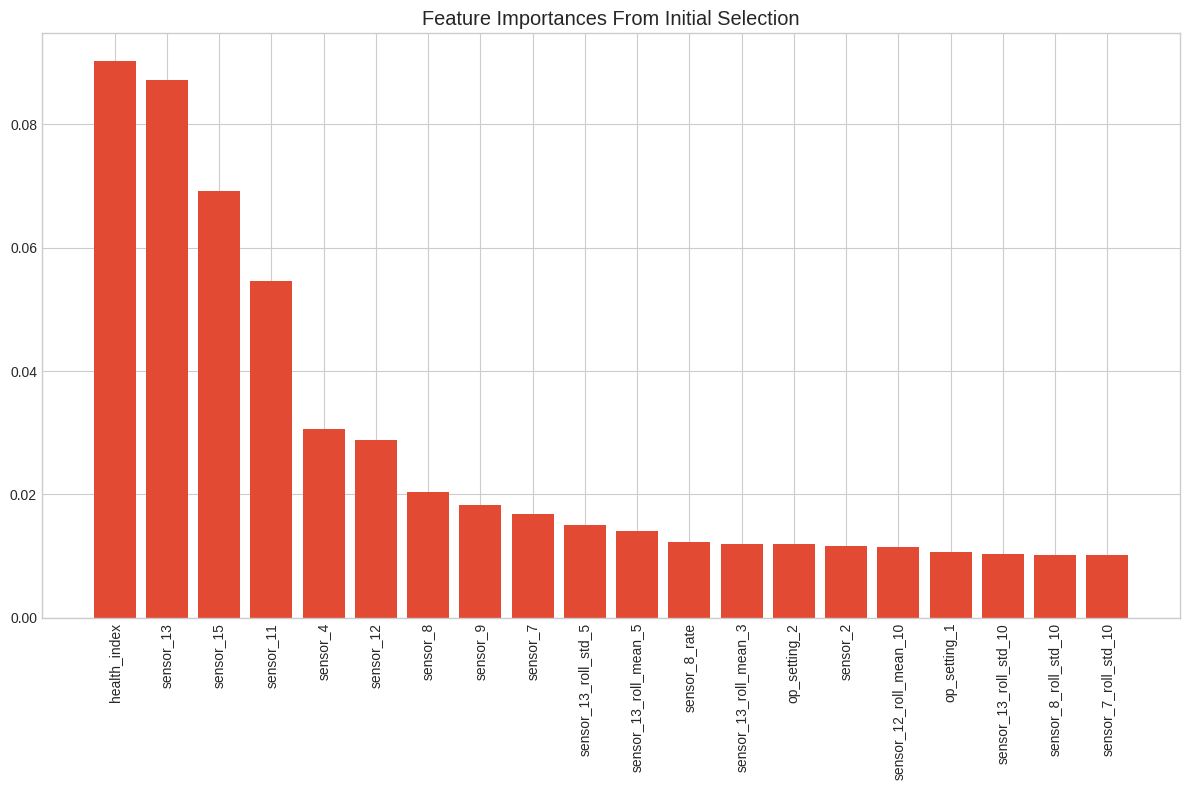


Training XGBoost classifier with hyperparameter tuning...
Fitting 3 folds for each of 108 candidates, totalling 324 fits
Best parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.8}

Model Performance Metrics:
Accuracy: 0.8400
Precision: 0.8425
Recall: 0.8400
F1 Score: 0.8410

Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.95      0.91      0.93       400
         Warning       0.75      0.78      0.77       400
Imminent Failure       0.83      0.83      0.83       400

        accuracy                           0.84      1200
       macro avg       0.84      0.84      0.84      1200
    weighted avg       0.84      0.84      0.84      1200



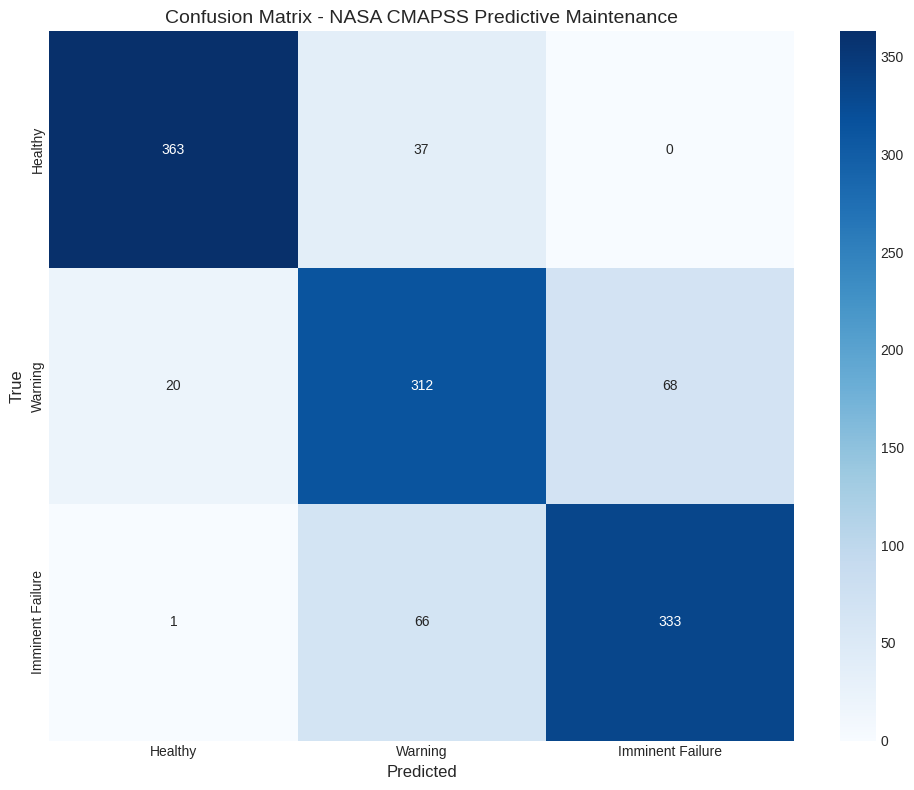

<Figure size 1200x800 with 0 Axes>

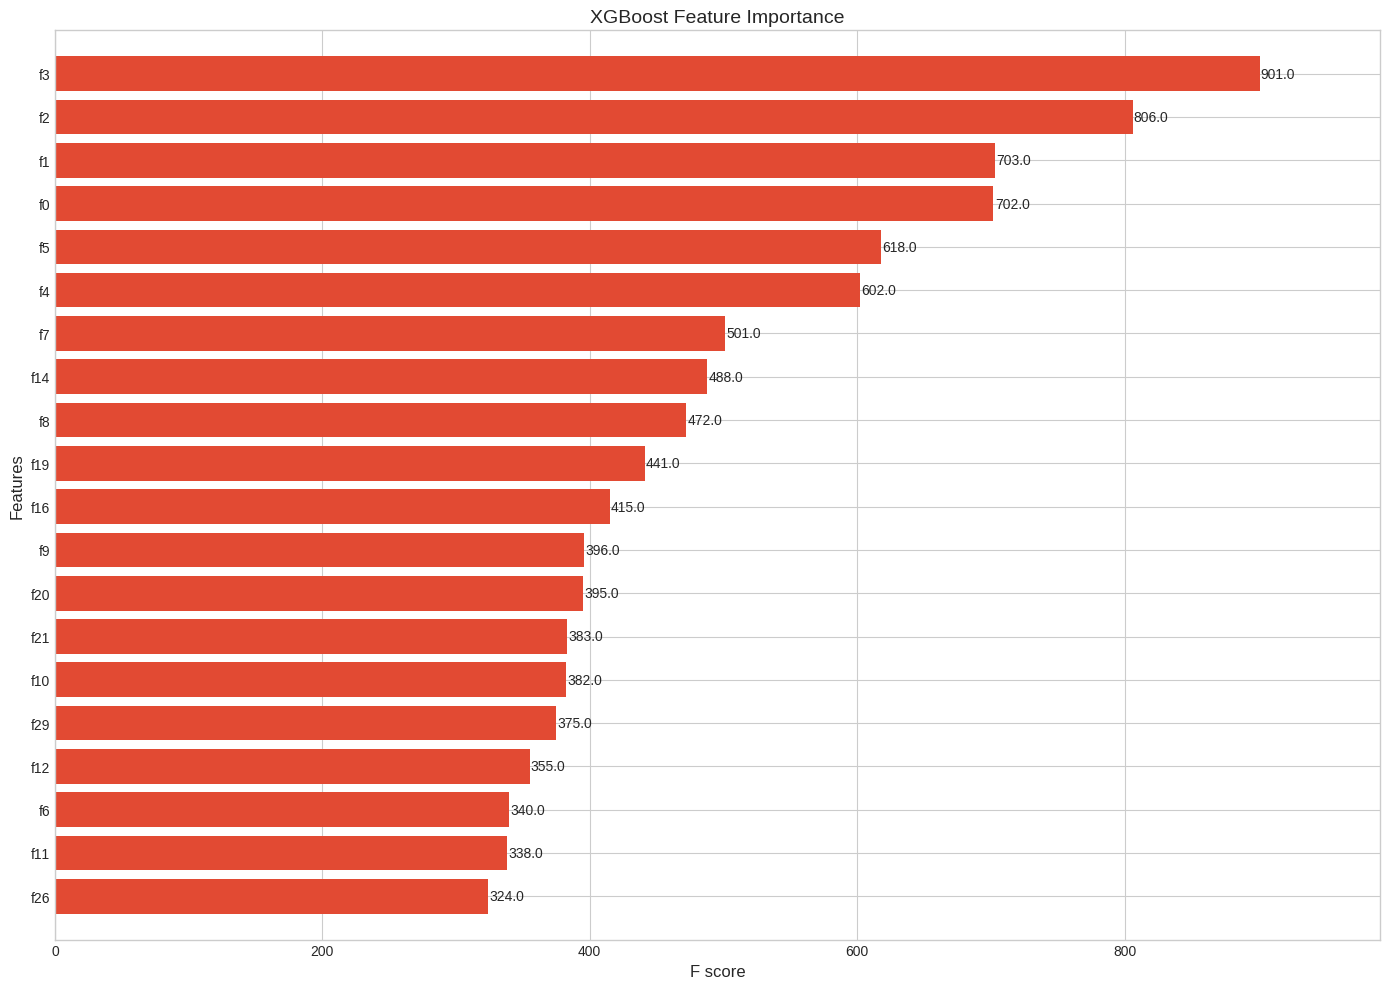


Generating SHAP explanations for XGBoost model...
Using TreeExplainer (optimized for tree-based models like XGBoost)
Calculating SHAP values for 100 test samples...


<Figure size 1400x1000 with 0 Axes>

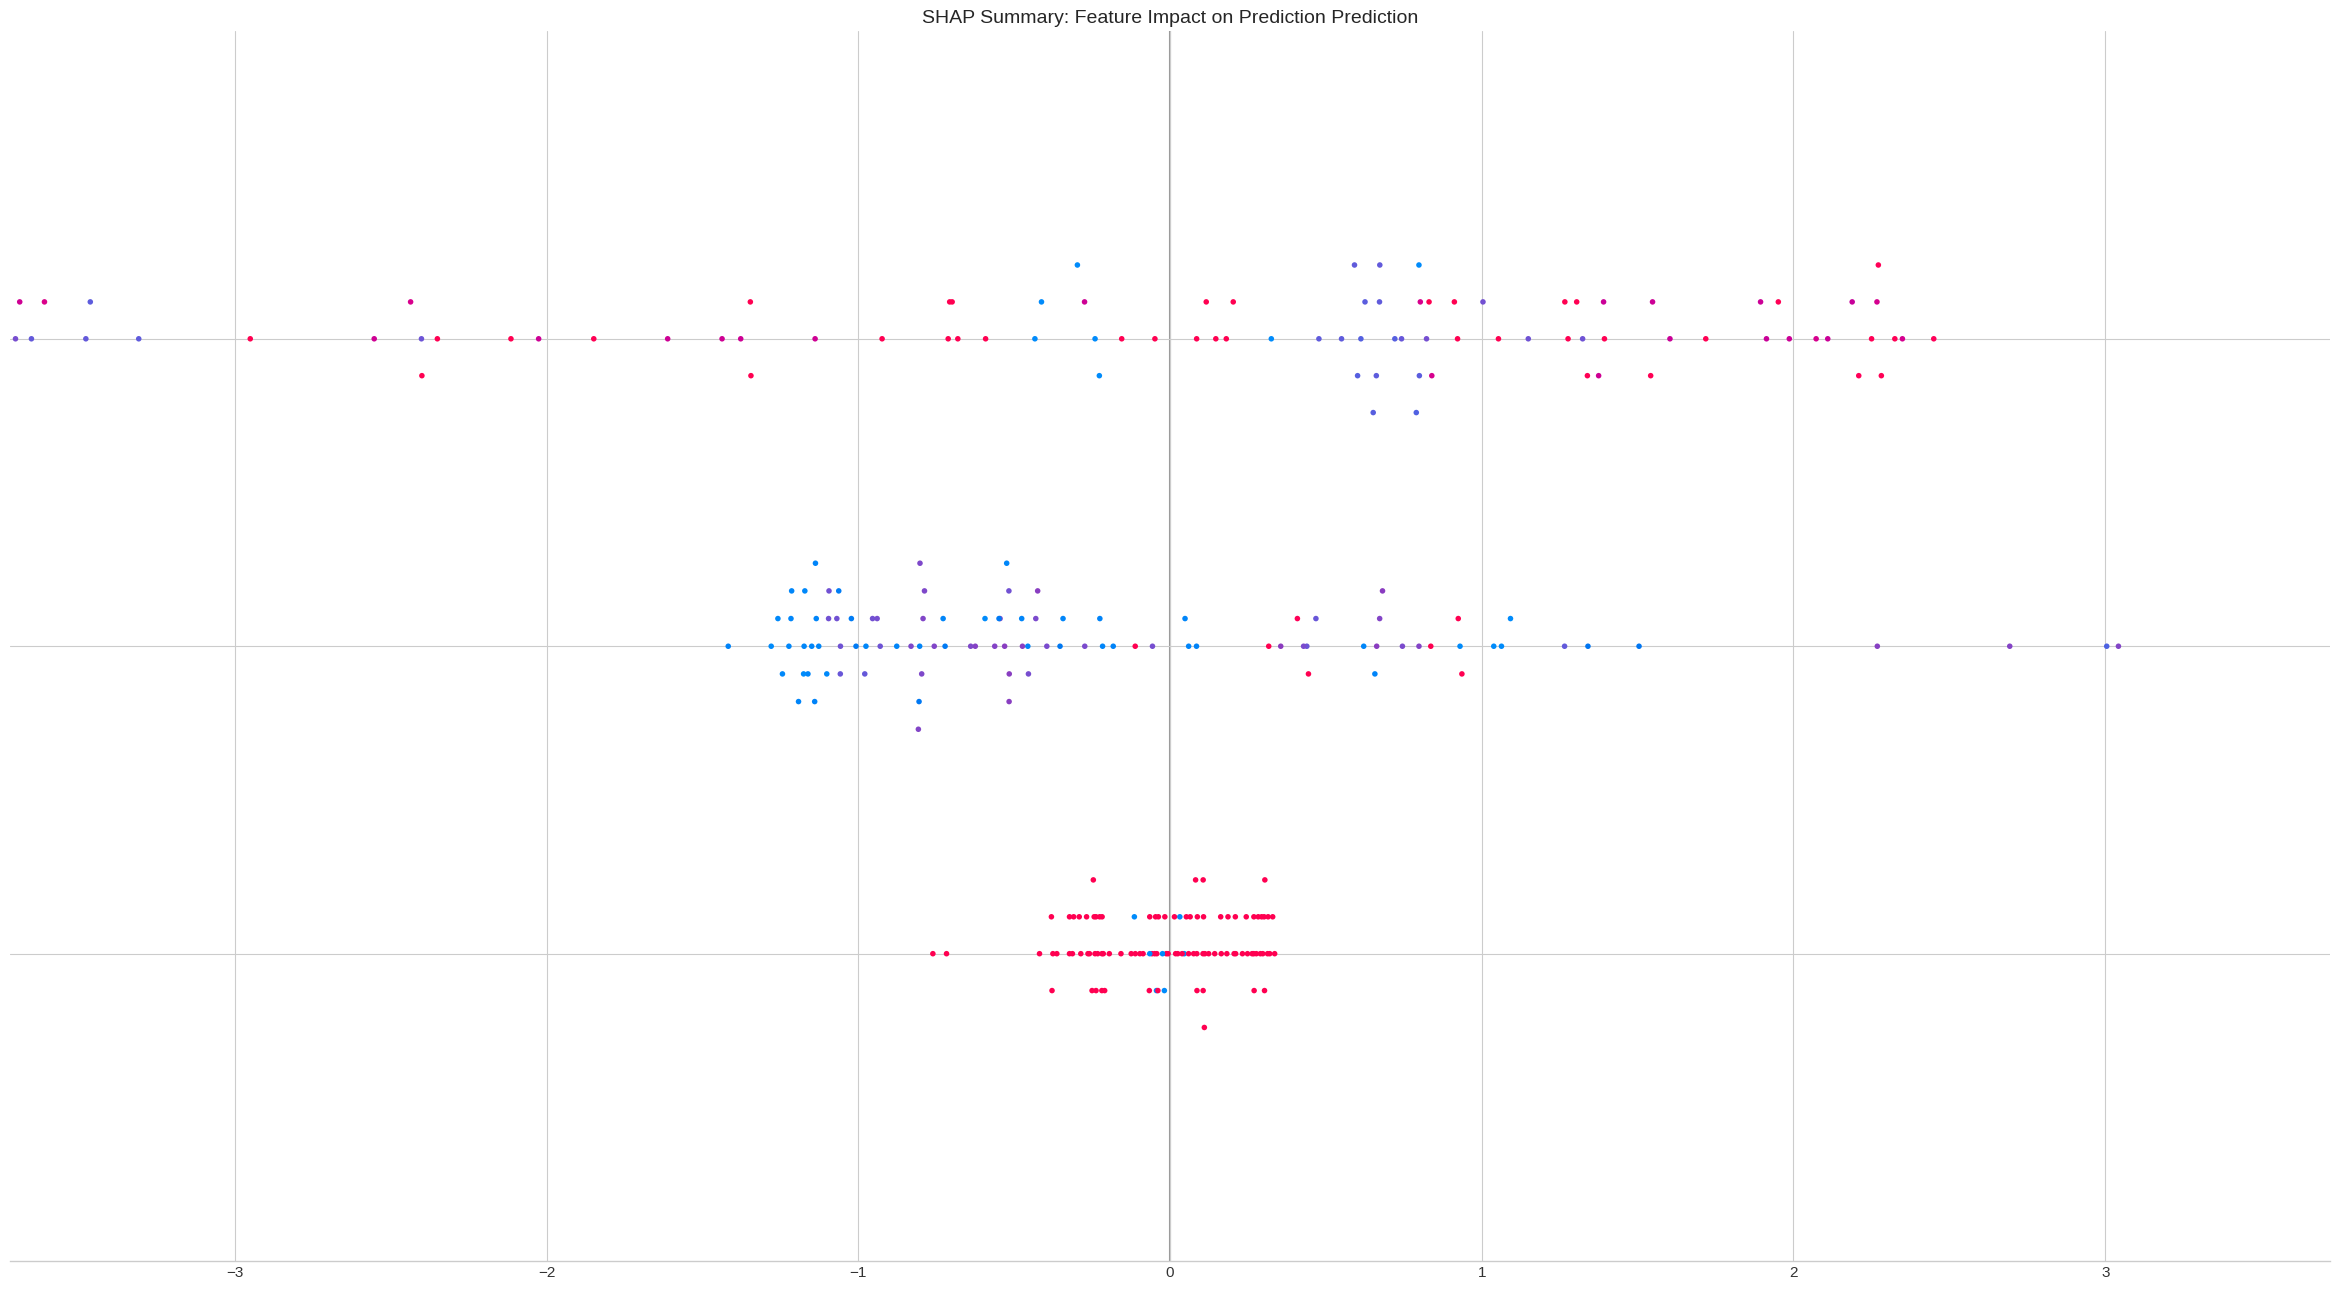

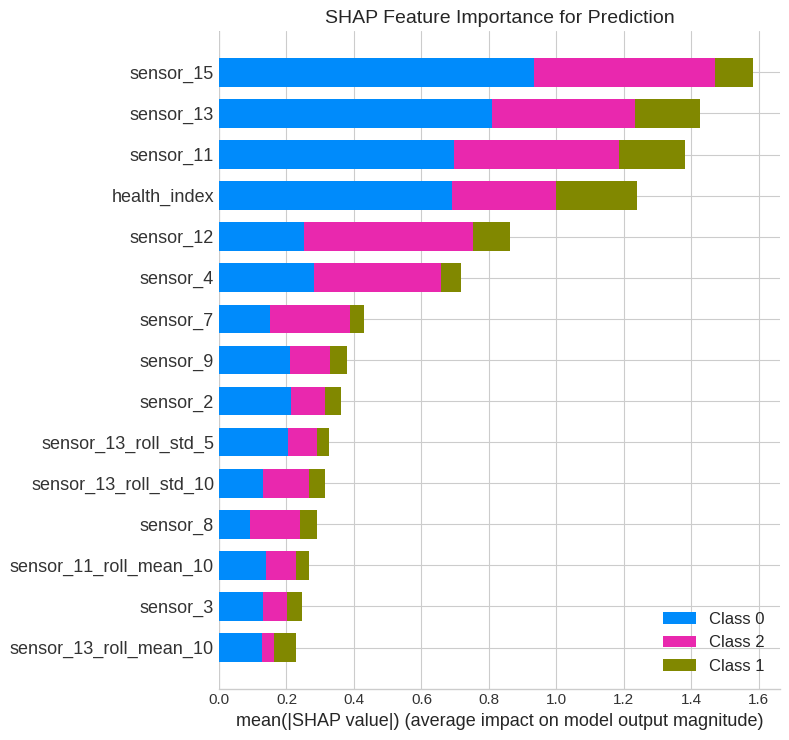

Error in SHAP visualization: cannot access local variable 'failure_class_idx' where it is not associated with a value

Generating LIME explanations...


Traceback (most recent call last):
  File "<ipython-input-4-124621c98c8d>", line 357, in explain_with_shap
    expected_value = explainer.expected_value[failure_class_idx]
                                              ^^^^^^^^^^^^^^^^^
UnboundLocalError: cannot access local variable 'failure_class_idx' where it is not associated with a value


<Figure size 1400x700 with 0 Axes>

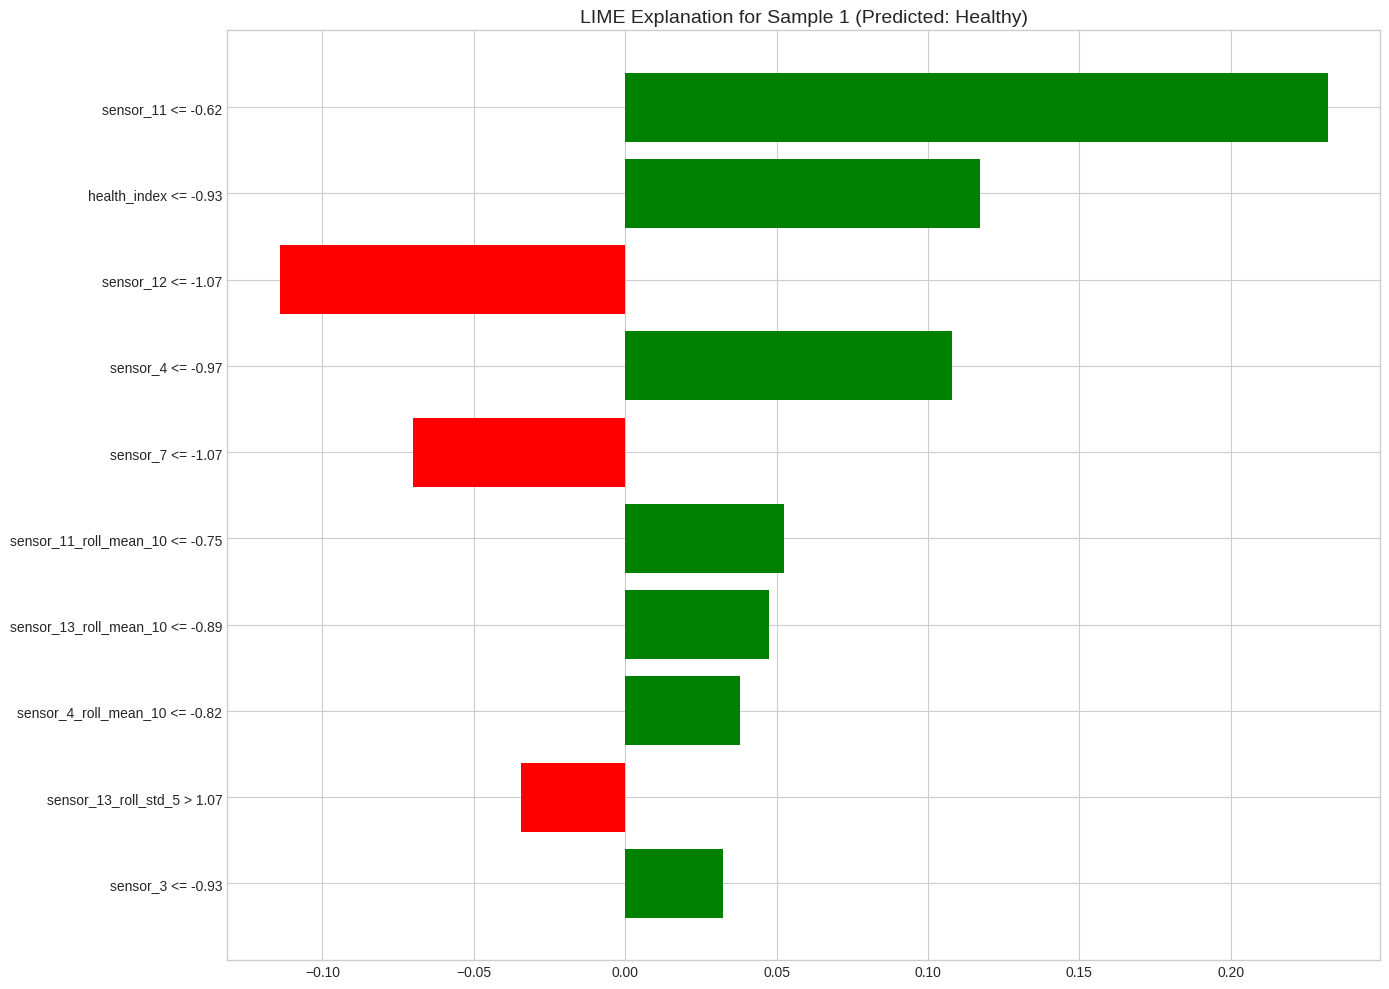


Feature contributions for Sample 1 (Predicted: Healthy):
  sensor_11 <= -0.62: +0.2320
  health_index <= -0.93: +0.1171
  sensor_12 <= -1.07: -0.1141
  sensor_4 <= -0.97: +0.1081
  sensor_7 <= -1.07: -0.0701
  sensor_11_roll_mean_10 <= -0.75: +0.0526
  sensor_13_roll_mean_10 <= -0.89: +0.0475
  sensor_4_roll_mean_10 <= -0.82: +0.0378
  sensor_13_roll_std_5 > 1.07: -0.0345
  sensor_3 <= -0.93: +0.0324


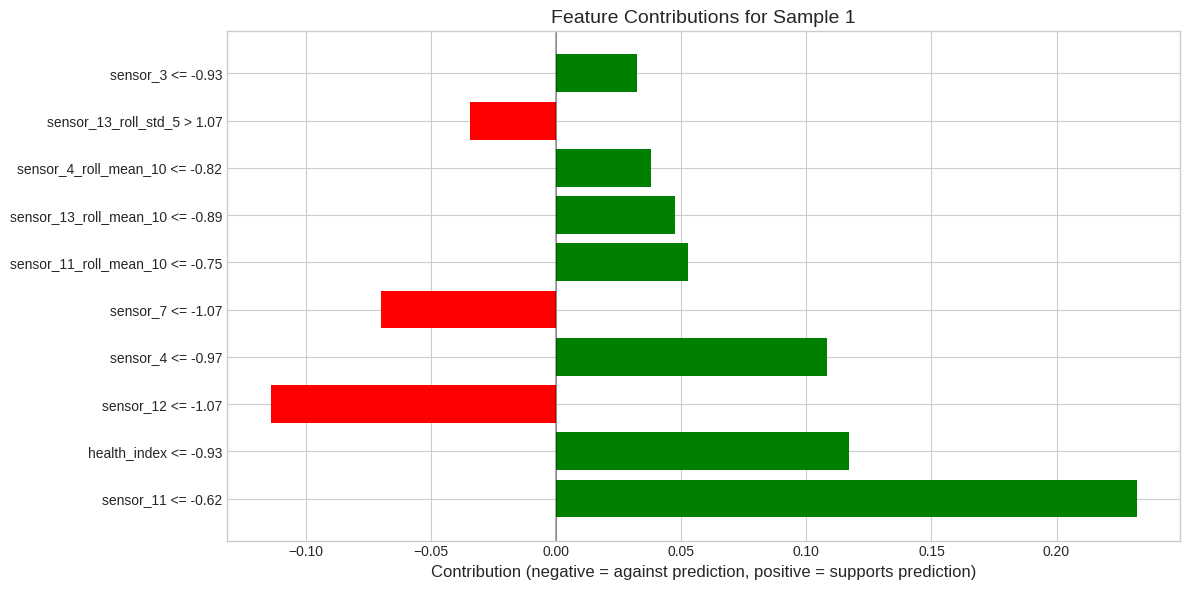

<Figure size 1400x700 with 0 Axes>

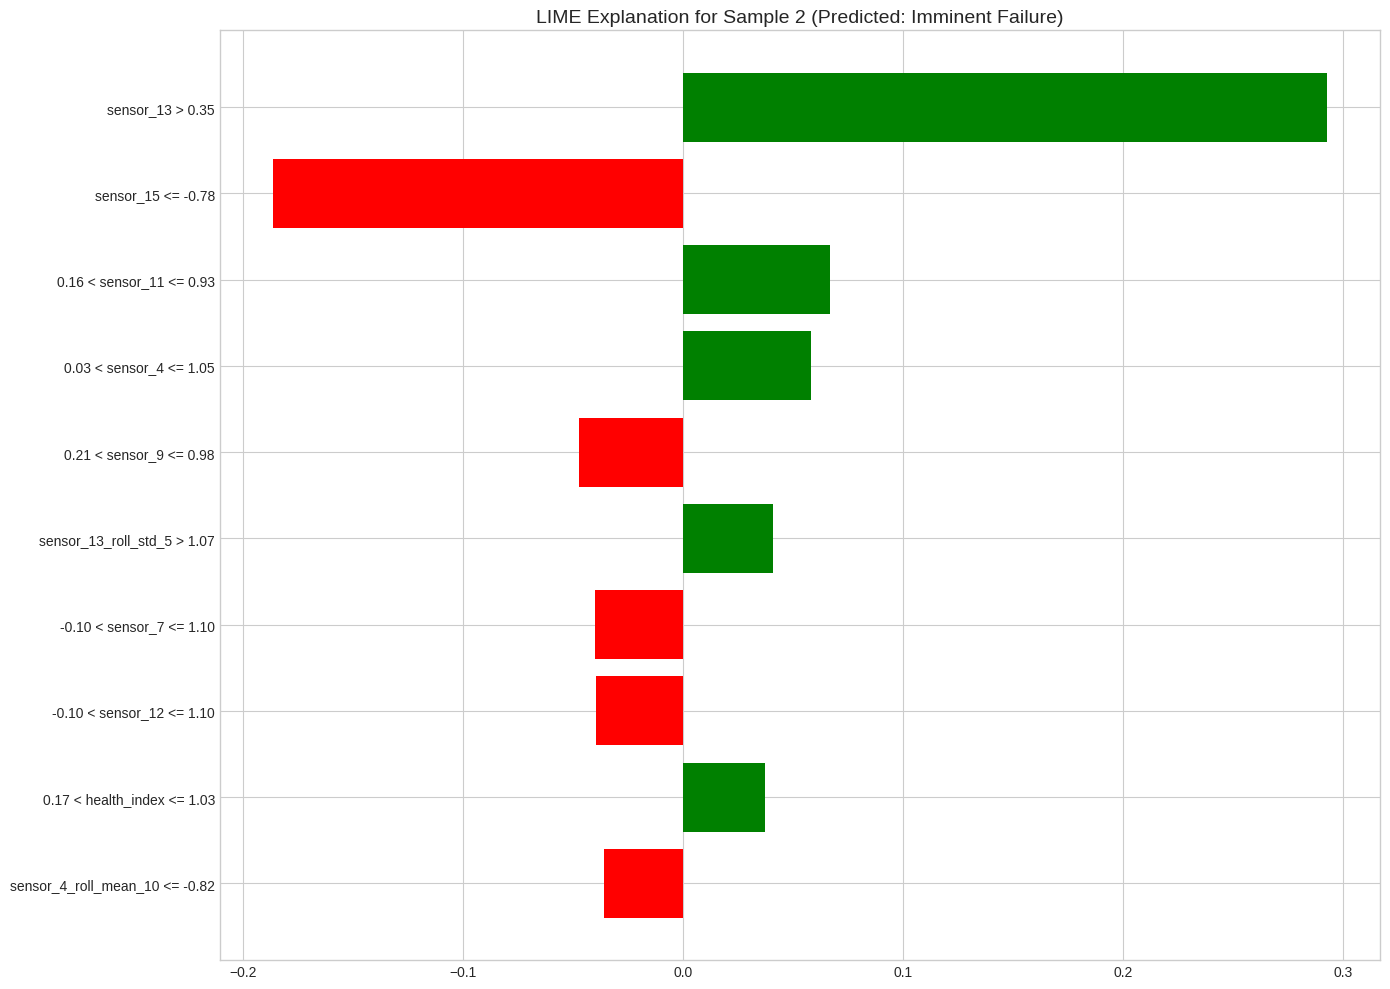


Feature contributions for Sample 2 (Predicted: Imminent Failure):
  sensor_13 > 0.35: +0.2927
  sensor_15 <= -0.78: -0.1866
  0.16 < sensor_11 <= 0.93: +0.0665
  0.03 < sensor_4 <= 1.05: +0.0582
  0.21 < sensor_9 <= 0.98: -0.0475
  sensor_13_roll_std_5 > 1.07: +0.0407
  -0.10 < sensor_7 <= 1.10: -0.0399
  -0.10 < sensor_12 <= 1.10: -0.0395
  0.17 < health_index <= 1.03: +0.0371
  sensor_4_roll_mean_10 <= -0.82: -0.0362


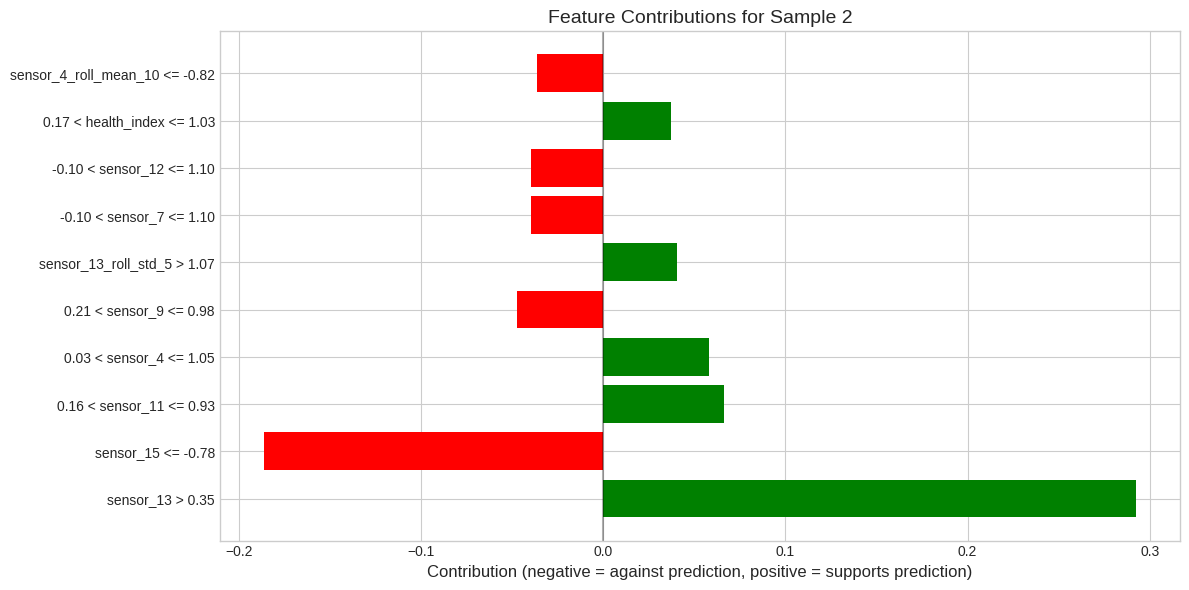

<Figure size 1400x700 with 0 Axes>

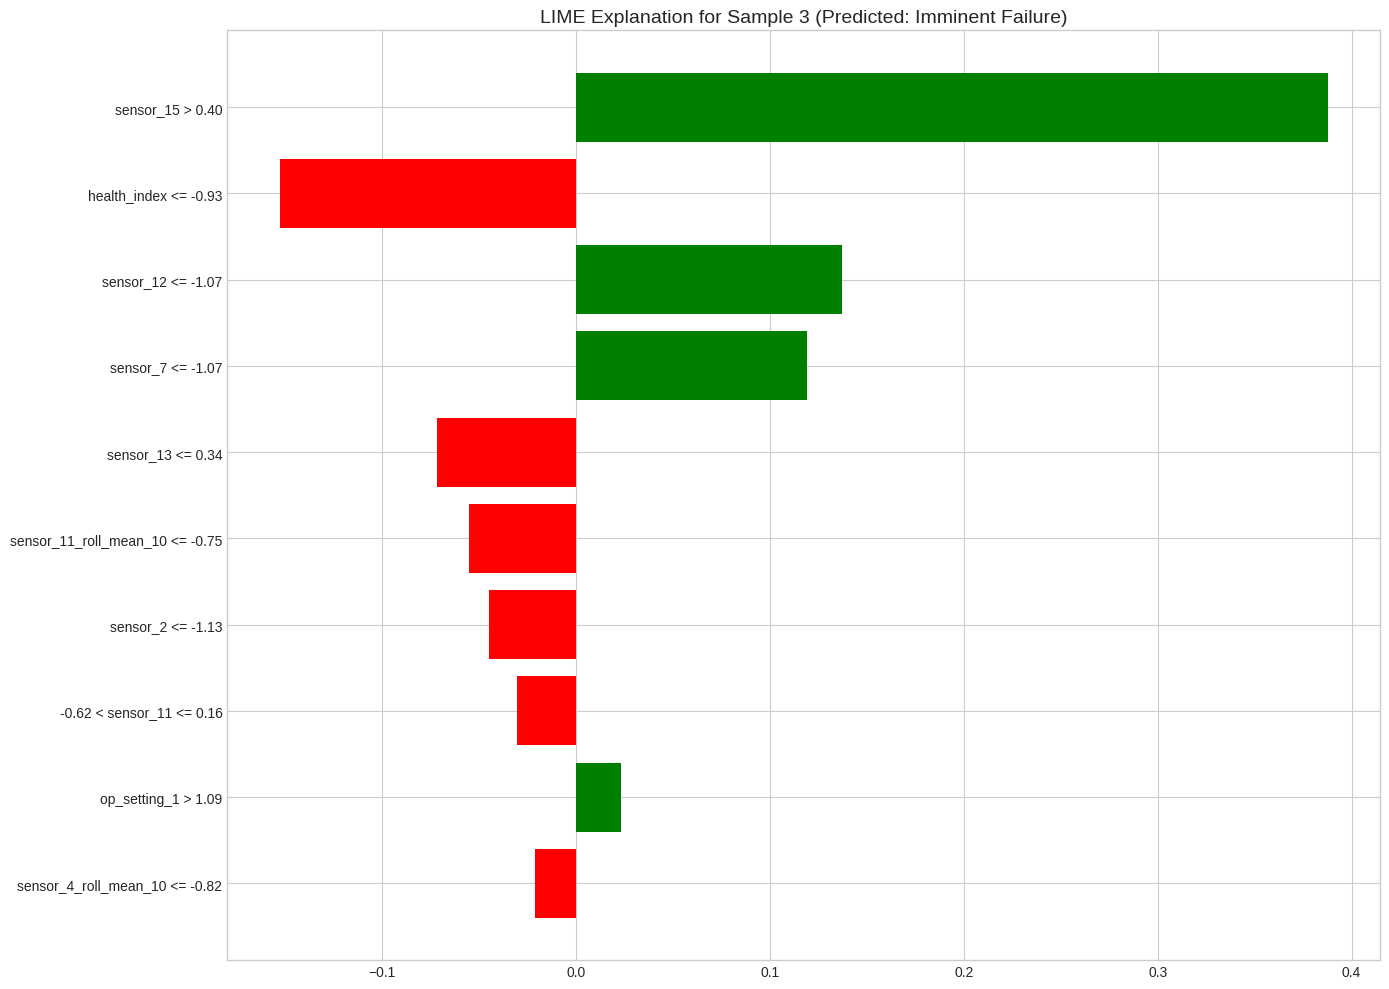


Feature contributions for Sample 3 (Predicted: Imminent Failure):
  sensor_15 > 0.40: +0.3876
  health_index <= -0.93: -0.1528
  sensor_12 <= -1.07: +0.1370
  sensor_7 <= -1.07: +0.1189
  sensor_13 <= 0.34: -0.0719
  sensor_11_roll_mean_10 <= -0.75: -0.0552
  sensor_2 <= -1.13: -0.0450
  -0.62 < sensor_11 <= 0.16: -0.0303
  op_setting_1 > 1.09: +0.0232
  sensor_4_roll_mean_10 <= -0.82: -0.0210


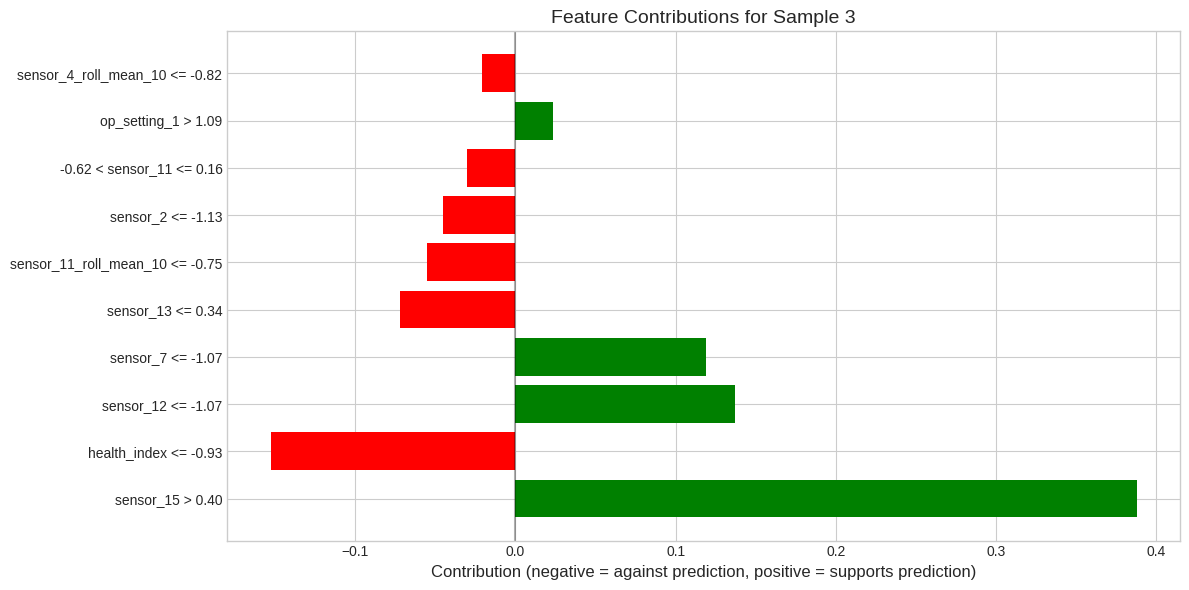

LIME explanations completed successfully

Calculating permutation importance...


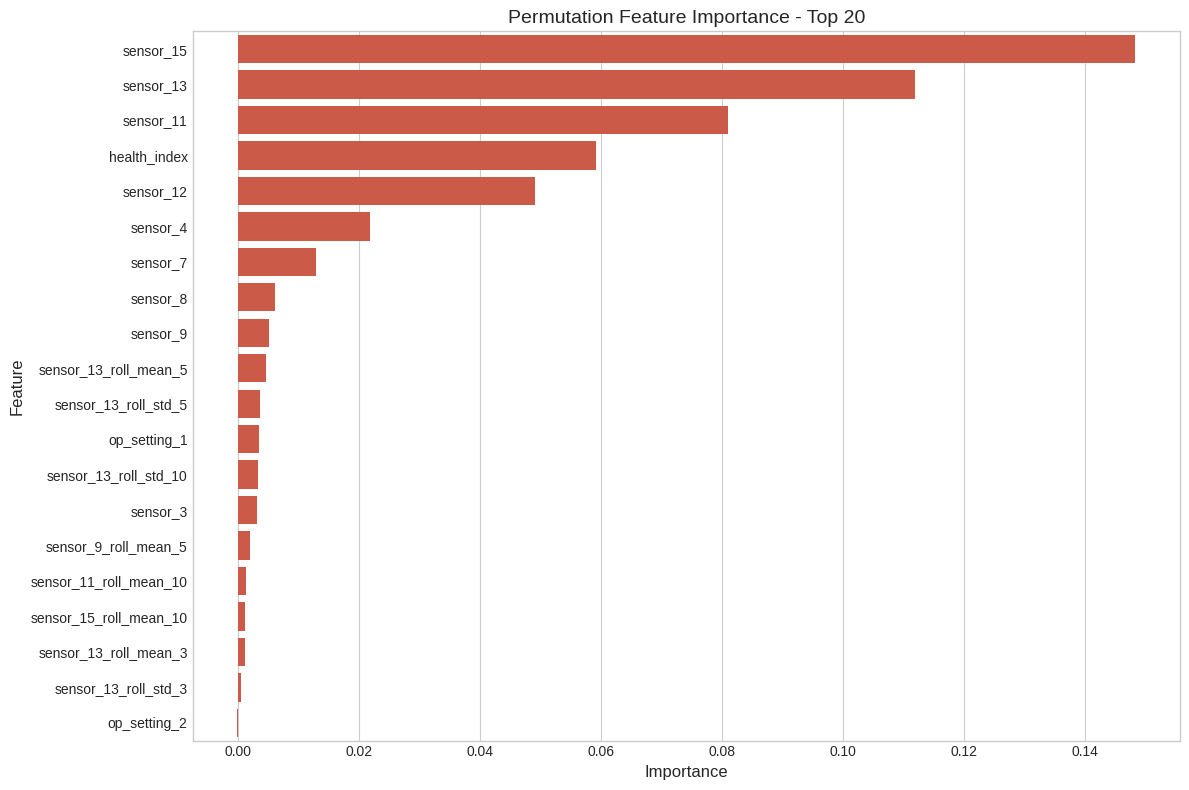


Top 10 features by permutation importance:
                  Feature  Importance   Std_Dev
2               sensor_15    0.148250  0.008854
1               sensor_13    0.111917  0.009604
3               sensor_11    0.080917  0.006438
0            health_index    0.059167  0.005503
5               sensor_12    0.049000  0.005107
4                sensor_4    0.021833  0.003993
8                sensor_7    0.012750  0.004442
6                sensor_8    0.006083  0.002790
7                sensor_9    0.005083  0.002849
10  sensor_13_roll_mean_5    0.004583  0.002479

Total execution time: 478.68 seconds (7.98 minutes)

NASA CMAPSS Predictive Maintenance with XGBoost and XAI completed successfully.


In [ ]:
# Complete NASA CMAPSS Turbofan Predictive Maintenance with XGBoost and XAI
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.neighbors import NearestNeighbors
from sklearn.inspection import permutation_importance
import xgboost as xgb
import shap
from lime.lime_tabular import LimeTabularExplainer
import time
from joblib import Parallel, delayed
import warnings
warnings.filterwarnings('ignore')

# Configure matplotlib to display plots inline
%matplotlib inline
plt.rcParams['figure.figsize'] = (14, 10)
plt.style.use('seaborn-v0_8-whitegrid')

# Start timing execution
start_time = time.time()

print("NASA CMAPSS Dataset - Predictive Maintenance with XGBoost and XAI")
print("------------------------------------------------------------------")

# Data loading function for NASA CMAPSS dataset
def load_CMAPSS_data(dataset_path, fd_number):
    """Load NASA CMAPSS dataset"""
    print(f"Loading dataset FD{fd_number}...")

    # Define column names for the dataset
    col_names = ['engine_id', 'cycle', 'op_setting_1', 'op_setting_2', 'op_setting_3'] + [
        f'sensor_{i}' for i in range(1, 22)
    ]

    try:
        # Load training data
        train_file = f"{dataset_path}/train_FD{fd_number}.txt"
        train_df = pd.read_csv(train_file, sep='\s+', header=None, names=col_names)

        # Calculate RUL (Remaining Useful Life)
        grouped = train_df.groupby('engine_id')
        max_cycles = grouped['cycle'].max().reset_index()
        max_cycles.columns = ['engine_id', 'max_cycle']

        train_df = train_df.merge(max_cycles, on='engine_id')
        train_df['RUL'] = train_df['max_cycle'] - train_df['cycle']

        # Remove unnecessary columns
        train_df.drop('max_cycle', axis=1, inplace=True)

        return train_df

    except Exception as e:
        print(f"Error loading dataset FD{fd_number}: {str(e)}")
        return pd.DataFrame()

# Optimized hypergraph balancing function
def optimized_hypergraph_balancing(df, class_column, target_samples_per_class=None):
    """Efficient hypergraph-based balancing with optimized processing"""
    print("Performing optimized hypergraph-based balancing...")

    # Get class counts and determine if balancing is needed
    class_counts = df[class_column].value_counts()
    print(f"Original class distribution: {class_counts.to_dict()}")

    # Determine target samples per class
    if target_samples_per_class is None:
        target_samples_per_class = class_counts.max()
        print(f"Target samples per class set to: {target_samples_per_class}")

    # Use parallel processing for efficiency
    balanced_dfs = Parallel(n_jobs=-1)(
        delayed(balance_single_class)(
            df, class_label, class_counts[class_label], target_samples_per_class, class_column
        ) for class_label in class_counts.index
    )

    # Combine all balanced dataframes
    balanced_df = pd.concat(balanced_dfs, ignore_index=True)

    # Verify the balanced class distribution
    balanced_counts = balanced_df[class_column].value_counts()
    print(f"Balanced class distribution: {balanced_counts.to_dict()}")

    return balanced_df

# Helper function for parallelized class balancing
def balance_single_class(df, class_label, class_size, target_samples, class_column):
    """Process a single class for balancing - for parallel execution"""
    # Filter data for this class
    class_data = df[df[class_column] == class_label]

    # Fast path for classes that already have enough samples
    if class_size >= target_samples:
        return class_data.sample(target_samples)

    # For classes that need upsampling, use hypergraph-based approach
    print(f"Applying hypergraph-based selection for class {class_label}")

    # Extract features for hypergraph construction - exclude non-feature columns
    exclude_cols = ['engine_id', 'cycle', 'RUL', class_column]
    feature_cols = [col for col in class_data.columns if col not in exclude_cols]

    X = class_data[feature_cols].values

    if len(X) <= 1:
        # If only one sample in class, just duplicate it
        return pd.concat([class_data] * target_samples).head(target_samples)

    # Efficient implementation of k-nearest neighbors using Ball Tree
    k = min(15, len(X) - 1)  # Number of neighbors
    nn = NearestNeighbors(n_neighbors=k+1, algorithm='ball_tree', n_jobs=-1)
    nn.fit(X)
    distances, indices = nn.kneighbors(X)

    # Vectorized calculation of confidence scores
    confidence_scores = np.mean(distances[:, 1:], axis=1)

    # Divide samples into approximation regions
    confidence_threshold = np.percentile(confidence_scores, 70)
    lower_approx_indices = np.where(confidence_scores < confidence_threshold)[0]
    boundary_indices = np.where(confidence_scores >= confidence_threshold)[0]

    # Calculate how many more samples we need
    remaining_samples = target_samples - len(lower_approx_indices)

    if remaining_samples > 0 and len(boundary_indices) > 0:
        # Select samples from boundary region efficiently
        boundary_probs = 1.0 / (1.0 + confidence_scores[boundary_indices])
        boundary_probs = boundary_probs / boundary_probs.sum()

        # Sample with replacement if needed
        replace = remaining_samples > len(boundary_indices)

        # Use efficient numpy operations
        selected_boundary = np.random.choice(
            boundary_indices,
            size=min(remaining_samples, len(boundary_indices)),
            replace=replace,
            p=boundary_probs
        )

        # Combine regions
        selected_indices = np.concatenate([lower_approx_indices, selected_boundary])
    else:
        selected_indices = lower_approx_indices

    # Handle edge cases efficiently
    if len(selected_indices) < target_samples:
        # Need more samples - duplicate some
        remaining = target_samples - len(selected_indices)
        duplicates = np.random.choice(range(len(X)), size=remaining, replace=True)
        selected_indices = np.concatenate([selected_indices, duplicates])
    elif len(selected_indices) > target_samples:
        # Too many samples - select subset
        selected_indices = np.random.choice(selected_indices, size=target_samples, replace=False)

    # Return balanced samples for this class
    return class_data.iloc[selected_indices].reset_index(drop=True)

# Efficient time-based feature creation with parallel processing
def create_time_features(df, sensors, window_sizes=[3, 5, 10]):
    """Create time-based features efficiently using parallel processing"""
    print("Creating time-based features with parallel processing...")

    # Sort data for accurate rolling calculations
    df = df.sort_values(['engine_id', 'cycle'])

    # Define operations to run in parallel
    def process_sensor_window(sensor, window):
        # Create mean features
        mean_name = f'{sensor}_roll_mean_{window}'
        mean_series = df.groupby('engine_id')[sensor].transform(
            lambda x: x.rolling(window, min_periods=1).mean())

        # Create std features
        std_name = f'{sensor}_roll_std_{window}'
        std_series = df.groupby('engine_id')[sensor].transform(
            lambda x: x.rolling(window, min_periods=1).std().fillna(0))

        return {mean_name: mean_series, std_name: std_series}

    # Run rolling window calculations in parallel
    results = Parallel(n_jobs=-1)(
        delayed(process_sensor_window)(sensor, window)
        for sensor in sensors
        for window in window_sizes
    )

    # Add results to dataframe
    for result in results:
        for name, series in result.items():
            df[name] = series

    # Add rate features more efficiently
    for sensor in sensors:
        # Calculate difference between consecutive sensor readings
        df[f'{sensor}_rate'] = df.groupby('engine_id')[sensor].diff().fillna(0)

        # Normalize by cycle difference
        cycle_diff = df.groupby('engine_id')['cycle'].diff().fillna(1)
        df[f'{sensor}_rate'] = df[f'{sensor}_rate'] / np.where(cycle_diff == 0, 1, cycle_diff)

    return df

# Create health index feature
def create_health_index(df, sensor_columns):
    """Create a health index feature based on multiple sensor readings"""
    print("Creating health index feature...")

    # Create a copy to avoid modifying original data
    normalized_sensors = df[sensor_columns].copy()

    # Normalize all sensors at once using vectorized operations
    for col in sensor_columns:
        min_val = df[col].min()
        max_val = df[col].max()

        # Handle case where min and max are the same
        if min_val == max_val:
            normalized_sensors[col] = 0.5
        else:
            normalized_sensors[col] = (df[col] - min_val) / (max_val - min_val)

    # Calculate health index efficiently
    df['health_index'] = normalized_sensors.mean(axis=1)

    return df

# Create three-class labels
def create_multiclass_labels(df, thresholds=[15, 30, 90]):
    """Create multi-class labels based on RUL thresholds"""
    print(f"Creating multi-class labels with thresholds {thresholds}...")

    # Create labels: 0 = healthy, 1 = warning, 2 = imminent failure
    conditions = [
        (df['RUL'] <= thresholds[0]),                               # Imminent failure
        (df['RUL'] > thresholds[0]) & (df['RUL'] <= thresholds[1]), # Warning
        (df['RUL'] > thresholds[1])                                 # Healthy
    ]

    values = [2, 1, 0]  # 2 = imminent failure, 1 = warning, 0 = healthy
    df['failure_class'] = np.select(conditions, values)

    return df

# Feature selection for dimensionality reduction
def select_important_features(X_train, y_train, feature_names, n_features=30):
    """Select important features to reduce dimensionality and improve performance"""
    print("Performing feature selection...")

    # Train a quick XGBoost model to get feature importances
    feature_selector = xgb.XGBClassifier(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=5,
        use_label_encoder=False,
        eval_metric='mlogloss',
        random_state=42
    )

    feature_selector.fit(X_train, y_train)

    # Get feature importances
    importance = feature_selector.feature_importances_
    indices = np.argsort(importance)[::-1]

    # Select top features
    selected_indices = indices[:n_features]
    selected_features = [feature_names[i] for i in selected_indices]

    print(f"Selected {len(selected_features)} features out of {len(feature_names)}")

    # Plot feature importance
    plt.figure(figsize=(12, 8))
    plt.title("Feature Importances From Initial Selection")
    plt.bar(range(min(20, len(selected_features))),
            importance[selected_indices[:20]],
            align="center")
    plt.xticks(range(min(20, len(selected_features))),
               [selected_features[i] for i in range(min(20, len(selected_features)))],
               rotation=90)
    plt.tight_layout()
    plt.show()

    return selected_indices, selected_features

# SHAP explainer function optimized for XGBoost
def explain_with_shap(model, X_train, X_test, selected_features, class_names):
    """Generate SHAP explanations that work well with XGBoost"""
    print("\nGenerating SHAP explanations for XGBoost model...")

    try:
        # Create a TreeExplainer - works directly with XGBoost
        explainer = shap.TreeExplainer(model)
        print("Using TreeExplainer (optimized for tree-based models like XGBoost)")

        # Calculate SHAP values - faster with XGBoost than with AdaBoost
        sample_size = min(100, X_test.shape[0])  # Use a subset for faster computation
        sample_indices = np.random.choice(X_test.shape[0], sample_size, replace=False)
        sample_data = X_test[sample_indices]

        print(f"Calculating SHAP values for {sample_size} test samples...")
        shap_values = explainer.shap_values(sample_data)

        # For multiclass problems, shap_values is a list of arrays (one per class)
        if isinstance(shap_values, list):
            print(f"Multi-class model with {len(shap_values)} classes detected")
            # Focus on the "Imminent Failure" class (index 2)
            failure_class_idx = 2
            shap_values_viz = shap_values[failure_class_idx]
            target_class = class_names[failure_class_idx]
        else:
            shap_values_viz = shap_values
            target_class = "Prediction"

        # Create numpy array of feature names for compatibility
        feature_names_array = np.array(selected_features)

        # 1. SHAP Summary Plot (beeswarm)
        plt.figure(figsize=(14, 10))
        shap.summary_plot(
            shap_values_viz,
            sample_data,
            feature_names=feature_names_array,
            max_display=15,
            show=False
        )
        plt.title(f'SHAP Summary: Feature Impact on {target_class} Prediction', fontsize=14)
        plt.tight_layout()
        plt.show()

        # 2. SHAP Bar Plot (feature importance)
        plt.figure(figsize=(14, 10))
        shap.summary_plot(
            shap_values_viz,
            sample_data,
            feature_names=feature_names_array,
            plot_type='bar',
            max_display=15,
            show=False
        )
        plt.title(f'SHAP Feature Importance for {target_class}', fontsize=14)
        plt.tight_layout()
        plt.show()

        # 3. SHAP Waterfall Plot for a sample prediction
        sample_idx = 0

        # Try force plot for first test sample
        if isinstance(explainer.expected_value, list):
            expected_value = explainer.expected_value[failure_class_idx]
        else:
            expected_value = explainer.expected_value

        plt.figure(figsize=(20, 3))
        force_plot = shap.force_plot(
            expected_value,
            shap_values_viz[sample_idx],
            sample_data[sample_idx],
            feature_names=feature_names_array,
            matplotlib=True,
            show=False
        )
        plt.title(f"SHAP Force Plot - Sample {sample_idx+1} Prediction Explanation", fontsize=14)
        plt.tight_layout()
        plt.show()

        # 4. SHAP Dependence Plots for top 3 features
        feature_importance = np.abs(shap_values_viz).mean(0)
        top_indices = np.argsort(-feature_importance)[:3]

        for i, idx in enumerate(top_indices):
            plt.figure(figsize=(12, 7))
            feature_idx = int(idx)  # Convert to integer
            feature_name = selected_features[feature_idx]

            # Create dependence plot
            shap.dependence_plot(
                ind=feature_idx,
                shap_values=shap_values_viz,
                features=sample_data,
                feature_names=feature_names_array,
                show=False
            )
            plt.title(f'SHAP Dependence Plot: How {feature_name} Affects Predictions', fontsize=14)
            plt.tight_layout()
            plt.show()

        print("SHAP visualizations completed successfully")
        return shap_values, explainer

    except Exception as e:
        print(f"Error in SHAP visualization: {str(e)}")
        import traceback
        traceback.print_exc()
        return None, None

# LIME explainer function for local explanations
def explain_with_lime(model, X_train, X_test, selected_features, class_names, num_samples=3):
    """Generate LIME explanations for individual samples"""
    print("\nGenerating LIME explanations...")

    try:
        # Create LIME explainer
        lime_explainer = LimeTabularExplainer(
            X_train,
            feature_names=selected_features,
            class_names=class_names,
            mode='classification',
            verbose=False  # Disable verbose output
        )

        # Generate explanations for selected samples
        for i in range(min(num_samples, X_test.shape[0])):
            # Generate explanation for this instance
            exp = lime_explainer.explain_instance(
                X_test[i],
                model.predict_proba,
                num_features=10,
                top_labels=1
            )

            # Get predicted class
            pred_class = int(model.predict([X_test[i]])[0])

            # Display explanation
            plt.figure(figsize=(14, 7))
            exp.as_pyplot_figure(label=pred_class)
            plt.title(f'LIME Explanation for Sample {i+1} (Predicted: {class_names[pred_class]})', fontsize=14)
            plt.tight_layout()
            plt.show()

            # Show text explanation
            print(f"\nFeature contributions for Sample {i+1} (Predicted: {class_names[pred_class]}):")
            for feat, weight in exp.as_list(label=pred_class):
                print(f"  {feat}: {weight:+.4f}")

            # Create horizontal bar chart
            feature_weights = exp.as_list(label=pred_class)
            features, weights = zip(*feature_weights)

            plt.figure(figsize=(12, 6))
            colors = ['red' if w < 0 else 'green' for w in weights]
            y_pos = range(len(features))
            plt.barh(y_pos, weights, color=colors)
            plt.yticks(y_pos, features)
            plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)
            plt.title(f'Feature Contributions for Sample {i+1}', fontsize=14)
            plt.xlabel('Contribution (negative = against prediction, positive = supports prediction)')
            plt.tight_layout()
            plt.show()

        print("LIME explanations completed successfully")
        return lime_explainer

    except Exception as e:
        print(f"Error in LIME visualization: {str(e)}")
        import traceback
        traceback.print_exc()
        return None

# Main execution function
def main():
    try:
        # Set random seed for reproducibility
        np.random.seed(42)

        # Define path to dataset
        dataset_path = './'  # Adjust as needed

        # ----------------------
        # DATA LOADING
        # ----------------------
        print("Loading NASA CMAPSS datasets with parallel processing...")

        # Load traditional CMAPSS dataset (FD001-004)
        subsets = ['001', '002', '003', '004']
        all_data = []

        # Load each subset in parallel
        all_data = Parallel(n_jobs=-1)(
            delayed(load_CMAPSS_data)(dataset_path, fd) for fd in subsets
        )

        # Combine all loaded datasets
        full_data = pd.concat([df for df in all_data if not df.empty], ignore_index=True)

        # Check if data was loaded successfully
        if full_data.empty:
            raise ValueError("Failed to load datasets. Please check file paths and formats.")

        print(f"Dataset loaded successfully. Shape: {full_data.shape}")

        # ----------------------
        # FEATURE ENGINEERING
        # ----------------------

        # Identify critical sensors based on literature
        critical_sensors = [
            'sensor_2', 'sensor_3', 'sensor_4', 'sensor_7', 'sensor_8',
            'sensor_9', 'sensor_11', 'sensor_12', 'sensor_13', 'sensor_15'
        ]

        # Create time-based features efficiently
        full_data = create_time_features(full_data, critical_sensors, window_sizes=[3, 5, 10])

        # Create health index
        full_data = create_health_index(full_data, critical_sensors)

        # Create class labels
        full_data = create_multiclass_labels(full_data, thresholds=[15, 30, 90])

        # Check class distribution before balancing
        class_distribution = full_data['failure_class'].value_counts()
        print("\nClass distribution before balancing:")
        print(class_distribution)

        # ----------------------
        # HYPERGRAPH BALANCING
        # ----------------------

        # Apply optimized hypergraph-based balancing
        balanced_data = optimized_hypergraph_balancing(full_data, 'failure_class', target_samples_per_class=2000)

        # Create feature set
        features = critical_sensors + \
                  [f'{sensor}_roll_mean_{w}' for sensor in critical_sensors for w in [3, 5, 10]] + \
                  [f'{sensor}_roll_std_{w}' for sensor in critical_sensors for w in [3, 5, 10]] + \
                  [f'{sensor}_rate' for sensor in critical_sensors] + \
                  ['op_setting_1', 'op_setting_2', 'op_setting_3', 'health_index']

        # Drop rows with NaN values
        print(f"Shape before dropping NaN values: {balanced_data.shape}")
        balanced_data = balanced_data.dropna()
        print(f"Shape after dropping NaN values: {balanced_data.shape}")

        # ----------------------
        # MODEL TRAINING
        # ----------------------

        # Prepare features and target
        X = balanced_data[features].values
        y = balanced_data['failure_class'].values

        # Check for and handle problematic values
        mask = np.isfinite(X).all(axis=1)
        if not all(mask):
            print(f"Found {(~mask).sum()} rows with non-finite values. Removing them.")
            X = X[mask]
            y = y[mask]

        # Split data into train and test sets
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42, stratify=y
        )

        # Normalize features
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        # Perform feature selection to reduce dimensionality
        selected_indices, selected_features = select_important_features(
            X_train_scaled, y_train, features
        )

        # Use selected features only
        X_train_reduced = X_train_scaled[:, selected_indices]
        X_test_reduced = X_test_scaled[:, selected_indices]

        # Set up parameter grid for XGBoost hyperparameter tuning
        param_grid = {
            'max_depth': [3, 5, 7],
            'learning_rate': [0.01, 0.1, 0.2],
            'n_estimators': [50, 100, 200],
            'subsample': [0.8, 1.0],
            'colsample_bytree': [0.8, 1.0]
        }

        # Create XGBoost classifier
        print("\nTraining XGBoost classifier with hyperparameter tuning...")

        # Initialize base XGBoost model
        xgb_base = xgb.XGBClassifier(
            objective='multi:softprob',  # Multi-class probability output
            eval_metric='mlogloss',      # Multi-class log loss
            use_label_encoder=False,     # Avoid warning
            random_state=42
        )

        # Grid search with reduced CV for efficiency
        grid_search = GridSearchCV(
            xgb_base,
            param_grid,
            cv=3,
            scoring='accuracy',
            n_jobs=-1,
            verbose=1
        )

        # Train model
        grid_search.fit(X_train_reduced, y_train)

        print(f"Best parameters: {grid_search.best_params_}")

        # Get the best model
        best_model = grid_search.best_estimator_

        # Predict on test set
        y_pred = best_model.predict(X_test_reduced)

        # Calculate metrics
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='weighted')
        recall = recall_score(y_test, y_pred, average='weighted')
        f1 = f1_score(y_test, y_pred, average='weighted')

        print("\nModel Performance Metrics:")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1 Score: {f1:.4f}")

        # Define class names
        class_names = ['Healthy', 'Warning', 'Imminent Failure']

        # Classification report
        print("\nClassification Report:")
        print(classification_report(y_test, y_pred, target_names=class_names))

        # Confusion Matrix
        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=class_names,
                    yticklabels=class_names)
        plt.title('Confusion Matrix - NASA CMAPSS Predictive Maintenance', fontsize=14)
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.tight_layout()
        plt.show()

        # ----------------------
        # EXPLAINABLE AI SECTION
        # ----------------------

        # 1. Feature Importance from XGBoost
        plt.figure(figsize=(12, 8))
        xgb.plot_importance(best_model, max_num_features=20, height=0.8)
        plt.title('XGBoost Feature Importance', fontsize=14)
        plt.tight_layout()
        plt.show()

        # 2. SHAP Explanations - works well with XGBoost
        shap_values, shap_explainer = explain_with_shap(
            best_model,
            X_train_reduced,
            X_test_reduced,
            selected_features,
            class_names
        )

        # 3. LIME Explanations
        lime_explainer = explain_with_lime(
            best_model,
            X_train_reduced,
            X_test_reduced,
            selected_features,
            class_names
        )

        # 4. Permutation Importance
        print("\nCalculating permutation importance...")
        perm_importance = permutation_importance(
            best_model, X_test_reduced, y_test,
            n_repeats=10,
            random_state=42,
            n_jobs=-1
        )

        # Create DataFrame with permutation importance
        perm_importance_df = pd.DataFrame({
            'Feature': selected_features,
            'Importance': perm_importance.importances_mean,
            'Std_Dev': perm_importance.importances_std
        }).sort_values('Importance', ascending=False)

        # Plot permutation importance
        plt.figure(figsize=(12, 8))
        top_features = perm_importance_df.head(20)
        sns.barplot(x='Importance', y='Feature', data=top_features)
        plt.title('Permutation Feature Importance - Top 20', fontsize=14)
        plt.tight_layout()
        plt.show()

        print("\nTop 10 features by permutation importance:")
        print(perm_importance_df.head(10))

        # Calculate execution time
        execution_time = time.time() - start_time
        print(f"\nTotal execution time: {execution_time:.2f} seconds ({execution_time/60:.2f} minutes)")

        print("\nNASA CMAPSS Predictive Maintenance with XGBoost and XAI completed successfully.")

    except Exception as e:
        print(f"An error occurred: {str(e)}")
        import traceback
        traceback.print_exc()

# Run the main function
if __name__ == "__main__":
    main()
